# MBTI Project - Modeling (step 5)
<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This notebook contains the <b>Modeling</b> step which comes after the <b>Feature Engineering & Preprocessing</b> step. The main goal of this step involves selecting, training and deploying a model to make predictive insights.<p>
</div>

<div class="span5 alert alert-danger">

<h3>Disclaimer</h3>
    <p>The purpose of this notebook is to go over certain aspects of Natural Language Processing. There might be some parts of the notebook that do not have particular use for the future of this project but they are useful for learning purposes so I left them inside. I also would like to mention that some of the code here is recycled from online articles and notebooks on GitHub, I will try to mention every source as best as possible.
</div>

<a id=top><a>

<br>

### Table of Contents

- [Summarized goals](#goals)
- [Importing Libraries](#importing)
- [Review of our Dataset](#review)
- [Models Introduction](#model)
- [Parameters and Models](#parameters)
- [Stopwords](#stopwords)
- [Train Test Split](#train_test)
- [CountVectorizer and tf-id](#cv)
- [Report Function](#report)
- [Let's Start Modeling](#modeling) Every model is created with CountVectorizer, TF-IDF words, TF-IDF n_grams, TF-IDF characters
    - [MACHINE LEARNING](#ml)
        - [Multinomial Naive Bayes Models](#nb)  
        - [Logistic Regression](#lr)  
        - [Support Vector Machines](#svm)  
        - [K-Nearest Neightbors](#knn)  
        - [Random Forest](#NB)      
        - [Stocastic Gradient Descent](#sgd)
        - [Boosting](#boost)
            - [Gradient Boosting Classifier](#gbc)
            - [Catboost](#cb)
            - [Adaboost](#ab)        
            - [LightGBM](#lgbm)        
    - [DEEP LEARNING](#dl)
        - [Shallow Neural Network](#snn)
        - [Deep Neural Network](#dnn)
        - [Transformers](#trans)
            - [Analytics Vidya Example](#vidya)
            - [Paperspace Example](#paperspace)         
        
        
**Best models - Tunning**
- [Logistic Regression Models](#logistic)
    - [1st Model Logistic Regression with ContVectorizer](#logistic_cv)
    - [2nd Model Logistic Regression with with TF-IDF](#logistic_tf)
    - [3rd Model Logistic Regression with Google's trained Word2Vec model](#logistic_wv)        
- [Multinomial Naive Bayes Models](#naive_bayes)
    - [1st Model MultinomialNB](#multinomial)
    - [2nd Model MultinomialNB with Cross Validation](#multinomial2)    

<a id=goals></a>

## Summarized Goals
***

Find the best model that classifies each post into the pair of attributes of the MBTI:
 - Introversion vs. Extraversion (I vs. E)
 - Intuition vs. Sensing (N vs. S)
 - Thinking vs. Feeling (T vs. F)
 - Judging vs. Perceiving (J vs. P)

<a id=importing></a>

## Imports
***

In [1]:
# data wrangiling libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.transforms
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
sns.set() #

# natural language processing libraries
import nltk
import nltk.corpus 
import textstat

# other libraries
import os
import re
import random
import string
import pickle
import itertools
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="Progress!")
import time
import warnings
pd.options.mode.chained_assignment = None  # default='warn'

/Users/diego/.pyenv/versions/venv-MBTI/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('../../data/mbti_nlp.csv', index_col=0)

<a id=review></a>

<br>


## Reviewing our Dataset
***

In [3]:
df.columns

Index(['type', 'type_label', 'posts', 'I', 'J', 'N', 'T', 'NF', 'NT', 'SP',
       'SJ', 'text_clean', 'pos_tags', 'syllabel_count', 'lexicon_count',
       'sentence_count', 'flesch_reading', 'Flesch_Kincaid_Grade_Level',
       'Fog_Scale', 'Automated_Readability', 'Coleman_Liau',
       'Linsear_Write_Formula', 'Dale_Chall_Readability_Score',
       'readability_consensus', 'text_clean_joined'],
      dtype='object')

In [4]:
df.head()

,type,type_label,posts,I,J,N,T,NF,NT,SP,...,sentence_count,flesch_reading,Flesch_Kincaid_Grade_Level,Fog_Scale,Automated_Readability,Coleman_Liau,Linsear_Write_Formula,Dale_Chall_Readability_Score,readability_consensus,text_clean_joined
0,INFJ,8,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0,1,0,0,...,15,25.36,18.9,18.08,31.6,20.43,11.333333,9.00,18th and 19th grade,and intj moment sportscenter not top ten play ...
1,ENTP,3,'I'm finding the lack of me in these posts ver...,0,0,1,1,0,1,0,...,65,70.23,7.9,8.98,11.2,8.99,12.400000,6.53,8th and 9th grade,i m finding the lack of me in these post very ...
2,INTP,11,'Good one _____ https://www.youtube.com/wat...,1,0,1,1,0,1,0,...,30,52.02,12.8,13.18,17.4,11.03,11.600000,7.45,12th and 13th grade,good one course to which i say i know that s m...
3,INTJ,10,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1,0,1,0,...,43,54.86,11.7,12.89,13.8,8.71,13.000000,7.34,11th and 12th grade,dear intp i enjoyed our conversation the other...
4,ENTJ,2,'You're fired.|||That's another silly misconce...,0,1,1,1,0,1,0,...,54,61.77,9.1,10.23,12.5,10.55,6.555556,7.26,10th and 11th grade,you re fired that s another silly misconceptio...


<a id=model></a>

In [5]:
df.describe()

,type_label,I,J,N,T,NF,NT,SP,SJ,syllabel_count,lexicon_count,sentence_count,flesch_reading,Flesch_Kincaid_Grade_Level,Fog_Scale,Automated_Readability,Coleman_Liau,Linsear_Write_Formula,Dale_Chall_Readability_Score
count,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000,8675.000000
mean,8.230432,0.769568,0.395850,0.862017,0.458905,0.480346,0.381671,0.085879,0.052104,1749.386282,1219.609222,43.757925,15.017684,28.055424,29.633759,36.306190,9.750409,13.645152,9.159010
std,3.762924,0.421134,0.489061,0.344902,0.498337,0.499642,0.485825,0.280201,0.222249,418.831239,310.454862,24.590076,157.747792,59.769048,61.113524,77.207695,11.518357,10.564567,7.618835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,1.000000,-1727.450000,3.700000,1.600000,4.900000,4.170000,2.000000,0.200000
25%,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1503.500000,1042.000000,25.000000,40.295000,9.400000,10.780000,12.000000,8.030000,7.571429,6.700000
50%,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1821.000000,1271.000000,45.000000,57.230000,11.700000,13.060000,15.200000,8.990000,11.200000,7.170000
75%,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2059.000000,1449.000000,61.000000,65.860000,17.400000,18.500000,23.100000,10.110000,15.000000,7.990000
max,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2614.000000,1881.000000,135.000000,92.020000,698.600000,717.520000,894.000000,697.100000,92.000000,94.180000


<br>

## Models Introduction
***

<br>
<div class="span5 alert alert-danger">
    <p>NOTE: After playing around with the code below I saw that 16 categories were too many for the model to classify. I decided to start small by only comparing each individual attribute which allows us to have only two groups (Extraverts vs Introverts / Innutition vs. Sensing / Thinking vs. Feeling / Perceiving vs. Judging).<p>
</div>

In [6]:
# This piece generates four dataframes one for each pair of attributes
I = df[['I','text_clean_joined']]
N = df[['N','text_clean_joined']]
T = df[['T','text_clean_joined']]
J = df[['J','text_clean_joined']]

Here I will write down what my final goal and the process I plan to follow. I guess I will have to go back and forth again and again but I need a road map.

**Goal:** Use machine learning and deep learning models to classify each observation into:
 - Extraverts (E) vs Introverts (I)
 - Innutition (N) vs. Sensing (S)
 - Thinking (T) vs. Feeling (F)
 - Perceiving (P) vs. Judging (J)
 
 
**Process:**
 - Train/Test Split
 - Consider the possibilities among:
  - Using CountVectorizer vs. TF-IDF n-grams(2,3)
  - Using GridSearchCV vs RandomizedSearchCV vs. Auto-Tuning
  - Deciding metrics for evaluation
  - Decide on pretrained models (fastText)
  - Creating Machine Learning and Deep Learning models
     - Machine Learning:
        - Logistic Regression
        - Multinomial Naive Bayes
        - SVM
        - k-NN
        - Stochastic Gradient Descent
        - Gradient Boosting (XGBoostm, Adaboost, Catboost, LightGBM)
        - ExtraTrees Classifier.
     - Deep Learning:
        - Shallow Network
        - Deep Neaural Network
        - RNN
        - CNN
        - LSTM / CNN-LSTM
        - GRU / CNN-GRU
        - Bidirectional RNN / Bidirectional LSTM / Bidirectional GRU 
        - RCNN 
        - Transformers 
 - Save results
 - Final model selection
 - Conclusion
      

**Note** I will be using `Christophe Pere's` notebook as the basis for this model. All credits go to him, [here is the original notebook](https://github.com/Christophe-pere/Model-Selection/blob/master/Text_Classification_Compare_Models.ipynb) and here is his [TowardsDataScience article](https://towardsdatascience.com/model-selection-in-text-classification-ac13eedf6146)

In [7]:
import glob
import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

print(sklearn.__version__)

0.23.2


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2.3.1


In [9]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [10]:
import fasttext
import fasttext.util

In [11]:
# Functions to extract the true, false positive and true false negative
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

<a id=parameters></a>

## Parameters & Models
***

In [12]:
TEXT           = "text_clean_joined"
LABEL          = "T"
NAME_SAVE_FILE = "model_selection_results" # put just the name the .csv will be added at the end

# global parameters
num_gpu                = len(tf.config.experimental.list_physical_devices('GPU'))   # detect the number of gpu
CV_splits              = 5        # Number of splits for cross-validation and k-folds
save_results           = True     # if you want an output file containing all the results
lang                   = False    # test if you want to use Google API detection (you will need to "import from googletrans import Translator")
sample                 = True     # use just a sample of data
nb_sample              = 6000     # default value of rows if sample selected
save_model             = True     # concat all the data representation
root_dir               = "models/"       # Place here the path where you want your models stored or use /path/to/your/folder/

In [13]:
# These are the names how the files will be saved as 
NAME_ENCODER                  = "encoder.sav"
NAME_COUNT_VECT_MODEL         = "count_vect_model.sav"
NAME_TF_IDF_MODEL             = "TF_IDF_model.sav"
NAME_TF_IDF_NGRAM_MODEL       = "TF_IDF_ngram_model.sav"
NAME_TF_IDF_NGRAM_CHAR_MODEL  = "TF_IDF_ngram_chars_model.sav"
NAME_TOKEN_EMBEDDINGS         = "token_embeddings.sav"

In [16]:
# models 
multinomial_naive_bayes= True
logistic_regression    = True
svm_model              = True
k_nn_model             = True
sgd                    = True
random_forest          = True
gradient_boosting      = True
xgboost_classifier     = True
adaboost_classifier    = True 
catboost_classifier    = True 
lightgbm_classifier    = False 
extratrees_classifier  = True
shallow_network        = True
deep_nn                = True
rnn                    = True
lstm                   = True
cnn                    = True
gru                    = True
cnn_lstm               = True
cnn_gru                = True
bidirectional_rnn      = True
bidirectional_lstm     = True
bidirectional_gru      = True
rcnn                   = True
transformers           = False
pre_trained            = False

In [14]:
if save_model:
    # will create the folder to save all the models
    try:
        dir_name =  NAME_SAVE_FILE
        os.makedirs(os.path.join(root_dir,dir_name))
        print("The folder is created")
    except:
        print("The folder can not be created")

The folder can not be created


In [15]:
# Here you can put all the metrics you want (included in sklearn.metrics).
score_metrics = {'acc': accuracy_score,
               'balanced_accuracy': balanced_accuracy_score,
               'prec': precision_score,
               'recall': recall_score,
               'f1-score': f1_score,
               'tp': tp, 'tn': tn,
               'fp': fp, 'fn': fn,
               'cohens_kappa':cohen_kappa_score,
               'matthews_corrcoef':matthews_corrcoef,
               "roc_auc":roc_auc_score}

`Christophe Pere` has a set of functions to clean the text but we have already done that so I will not add them

<a id='stopwords'></a>

## Stopwords
***

In [17]:
# we will do add a remove stop words function
def remove_stop_words( x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)

In [18]:
# MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types = [x.lower() for x in df['type'].unique()] 
types_plural = [x+'s' for x in types]

# some words that appear a lot but do not add value
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf', 'ti','se','op','ne'] 

# We put these together and include the normal stopwords from the English language
stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

In [19]:
I[TEXT] = I.loc[:,TEXT].progress_apply(lambda x : remove_stop_words(x, stop_words))
N[TEXT] = N.loc[:,TEXT].progress_apply(lambda x : remove_stop_words(x, stop_words))
T[TEXT] = T.loc[:,TEXT].progress_apply(lambda x : remove_stop_words(x, stop_words))
J[TEXT] = J.loc[:,TEXT].progress_apply(lambda x : remove_stop_words(x, stop_words))

Progress!: 100%|██████████| 8675/8675 [00:02<00:00, 3247.86it/s]


<a id='train_test'></a>

## Train Test Split
***

To keep the code simple (for the time being), I will start by focusing on the `Thinking / Feeling` and later implement the same process for the rest.

In [37]:
df = T.copy()
X_train, X_test, y_train, y_test = train_test_split(df[TEXT], df[LABEL], test_size=0.25, random_state=42, stratify=df[LABEL])

**Personal note on stratify:** if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [38]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)

In [39]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 0.9241	class: 0
Class weight: 1.0894	class: 1


In [40]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df[LABEL].value_counts()) / np.max(df[LABEL].value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.848)


<a id='cv'></a>

## CountVectorizer & TF-IDF
***

This section transforms our data into something interpretable by the machine

In [41]:
%%time
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df[TEXT])

# transform the training and validation data using count vectorizer object
x_train_count =  count_vect.transform(X_train)
x_test_count =  count_vect.transform(X_test)

if save_model:
    # save the model to disk
    filename = NAME_COUNT_VECT_MODEL
    pickle.dump(count_vect, open(os.path.join(root_dir, dir_name,filename), 'wb'))

CPU times: user 7.07 s, sys: 135 ms, total: 7.21 s
Wall time: 7.31 s


In [54]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(df[TEXT])
x_train_tfidf =  tfidf_vect.transform(X_train)
x_test_tfidf =  tfidf_vect.transform(X_test)
print("word level tf-idf done")

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=10000)
tfidf_vect_ngram.fit(df[TEXT])
x_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
x_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
print("ngram level tf-idf done")

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=10000) 
tfidf_vect_ngram_chars.fit(df[TEXT])
x_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
x_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test) 
print("characters level tf-idf done")

if save_model:
    # save the model tf-idf to disk
    filename = NAME_TF_IDF_MODEL
    pickle.dump(tfidf_vect, open(os.path.join(root_dir, dir_name,filename), 'wb'))

    # save the model ngram to disk
    filename = NAME_TF_IDF_NGRAM_MODEL
    pickle.dump(tfidf_vect_ngram, open(os.path.join(root_dir, dir_name,filename), 'wb'))
    
    # save the model ngram char to disk
    filename = NAME_TF_IDF_NGRAM_CHAR_MODEL
    pickle.dump(tfidf_vect_ngram_chars, open(os.path.join(root_dir, dir_name,filename), 'wb'))

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 3min, sys: 6.05 s, total: 3min 6s
Wall time: 3min 21s


I had to download the pretrained fasttext model in english, this is the [link](https://fasttext.cc/docs/en/english-vectors.html). The zip file is 5.4GB so it is not included in the data folder.

<a id='report'></a>

## Report Function
***

The followign function will generate, for each model we create, a set of metrics that evaluate how well that model did

In [50]:
def report(clf, x, y, X_test, y_test, name='classifier', cv=5, dict_scoring=None, fit_params=None, save=save_model):
    '''
    Function create a metric report automatically with cross_validate function.
    @param clf: (model) classifier
    @param x: (list or matrix or tensor) training x data
    @param y: (list) label data 
    @param name: (string) name of the model (default classifier)
    @param cv: (int) number of fold for cross-validation (default 5)
    @param dict_scoring: (dict) dictionary of metrics and names
    @param fit_aparams: (dict) add parameters for model fitting 
    @param save: (bool) determine if the model need to be saved
    @return: (pandas.dataframe) dataframe containing all the results of the metrics 
    for each fold and the mean and std for each of them
    '''
    
    '''{'acc': accuracy_score,
               'balanced_accuracy': balanced_accuracy_score,
               'prec': precision_score,
               'recall': recall_score,
               'f1-score': f1_score,
               'tp': tp, 'tn': tn,
               'fp': fp, 'fn': fn,
               'cohens_kappa':cohen_kappa_score,
               'matthews_corrcoef':matthews_corrcoef,
               "roc_auc":roc_auc_score}'''
    
    
    if dict_scoring!=None:
        score = dict_scoring.copy() # save the original dictionary
        for i in score.keys():
            if len(set(y))>2:
                if i in ["prec", "recall", "f1-score"]:
                    score[i] = make_scorer(score[i], average = 'weighted') # make each function scorer
                elif i=="roc_auc":
                    score[i] = make_scorer(score[i], average = 'weighted', multi_class="ovo",needs_proba=True) # make each function scorer
                else:
                    score[i] = make_scorer(score[i]) # make each function scorer
                    
            else:
                score[i] = make_scorer(score[i]) # make each function scorer
            
    try:
        scores = cross_validate(clf, x, y, scoring=score,
                         cv=cv, return_train_score=False, n_jobs=-1,  fit_params=fit_params)
    except:
        scores = cross_validate(clf, x, y, scoring=score,
                         cv=cv, return_train_score=False,  fit_params=fit_params)
        
    # Train test on the overall data
    fit_start = time.time()
    _model = clf
    _model.fit(x, y)
        
    fit_end = time.time() - fit_start

    
    score_start = time.time()
    y_pred = _model.predict(X_test)#>0.5).astype(int)
    score_end = time.time() - score_start
    
    # this saves the model for reuse
    if save:
        filename= name+".sav"
        pickle.dump(_model, open(os.path.join(root_dir, dir_name,filename), 'wb'))
    
    # initialisation 
    index = []
    value = []
    index.append("Model")
    value.append(name)
    for i in scores:  # loop on each metric generate text and values
        if i == "estimator":
            continue
        for j in enumerate(scores[i]):
            index.append(i+"_cv"+str(j[0]+1))
            value.append(j[1])
        
        
        index.append(i+"_mean")
        value.append(np.mean(scores[i]))
        index.append(i+"_std")
        value.append(np.std(scores[i]))
    
     # add metrics averall dataset on the dictionary 
    
    for i in scores:    # compute metrics 
        if i == "fit_time":
            
            scores[i] = np.append(scores[i] ,fit_end)
            index.append(i.split("test_")[-1]+'_overall')
            value.append(fit_end)
            continue
        if i == "score_time":
            
            scores[i] = np.append(scores[i] ,score_end)
            index.append(i.split("test_")[-1]+'_overall')
            value.append(score_end)
            continue
              
        
        scores[i] = np.append(scores[i] ,score[i.split("test_")[-1]](_model, X_test, y_test))
        index.append(i.split("test_")[-1]+'_overall')
        value.append(scores[i][-1])
    
    return pd.DataFrame(data=value, index=index).T

<a id='modeling'></a>

## Let's Start Modeling!
***

In [51]:
# We start by creating the empty dataframe we will use to put the results of each model we create
df_results = pd.DataFrame()

<a id='ml'></a>

## Machine Learning Models

<a id='nb'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Multinomial Naïve Bayes</H5>
</div>

In [55]:
%%time
if multinomial_naive_bayes:
    df_results = df_results.append(report(naive_bayes.MultinomialNB(),x_train_count, y_train, x_test_count, y_test, name='NB_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(),x_train_tfidf, y_train, x_test_tfidf, y_test, name='NB_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(),x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='NB_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(),x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='NB_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))

CPU times: user 837 ms, sys: 343 ms, total: 1.18 s
Wall time: 7.94 s


<a id='lr'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Logistic Regression</H5>
</div>

In [61]:
%%time
if logistic_regression:
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), x_train_count, y_train, x_test_count, y_test, name='LR_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), x_train_tfidf, y_train, x_test_tfidf, y_test, name='LR_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='LR_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='LR_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))

CPU times: user 36 s, sys: 4.44 s, total: 40.5 s
Wall time: 1min


<a id='svm'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Support Vector Machine</H5>
</div>

In [67]:
%%time
if svm_model:
    df_results = df_results.append(report(svm.SVC(), x_train_count, y_train, x_test_count, y_test, name='SVM_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(svm.SVC(), x_train_tfidf, y_train, x_test_tfidf, y_test, name='SVM_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(svm.SVC(), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='SVM_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(svm.SVC(), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='SVM_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))

CPU times: user 1h 45min 54s, sys: 32.8 s, total: 1h 46min 27s
Wall time: 15h 45s


<a id='knn'></a>

<br>
<div class="span5 alert alert-info">
    <H5>K-Nearest Neighbors</H5>
</div>

In [70]:
%%time
if k_nn_model:
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), x_train_count, y_train, x_test_count, y_test, name='kNN_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), x_train_tfidf, y_train, x_test_tfidf, y_test, name='kNN_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='kNN_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test,  name='kNN_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))

CPU times: user 17min 29s, sys: 28.8 s, total: 17min 58s
Wall time: 8min 7s


<a id='rf'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Random Forest</H5>
</div>

In [107]:
%%time
if random_forest:
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), x_train_count, y_train, x_test_count, y_test, name='RF_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), x_train_tfidf, y_train, x_test_tfidf, y_test, name='RF_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='RF_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test,  name='RF_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))

CPU times: user 2min 53s, sys: 2.9 s, total: 2min 56s
Wall time: 4min 29s


<a id='sgd'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Stocastis Gradient Descent</H5>
</div>

Linear classifiers (SVM, logistic regression, etc.) with SGD training. This estimator implements regularized linear models with stochastic gradient descent (SGD) learning

In [74]:
%%time
if sgd:
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), x_train_count, y_train, x_test_count, y_test, name='SGD_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), x_train_tfidf, y_train, x_test_tfidf, y_test, name='SGD_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='SGD_N-Gram_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='SGD_CharLevel_Vectors', cv=CV_splits, dict_scoring=score_metrics, save=save_model))

CPU times: user 2.03 s, sys: 405 ms, total: 2.43 s
Wall time: 12.3 s


In [75]:
df_results

,Model,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,...,prec_overall,recall_overall,f1-score_overall,tp_overall,tn_overall,fp_overall,fn_overall,cohens_kappa_overall,matthews_corrcoef_overall,roc_auc_overall
0,NB_Count_Vectors,0.083657,0.087841,0.084295,0.0876408,0.0806589,0.0848186,0.00268425,0.0557067,0.0472348,...,0.791759,0.714573,0.751189,711,987,187,284,0.559446,0.561763,0.777644
0,NB_WordLevel_TF-IDF,0.0570619,0.0624511,0.0512819,0.0743842,0.034615,0.0559588,0.0131171,0.0463171,0.0433159,...,0.821277,0.58191,0.681176,579,1048,126,416,0.485369,0.504886,0.737292
0,NB_N-Gram_TF-IDF,0.0146081,0.031333,0.0386279,0.0167282,0.0169821,0.0236558,0.00956548,0.0413001,0.0396559,...,0.730563,0.547739,0.626077,545,973,201,450,0.383852,0.394977,0.688265
0,NB_CharLevel_TF-IDF,0.849732,0.797022,1.1039,1.13063,0.286705,0.833599,0.303969,0.125775,0.0687079,...,0.834646,0.106533,0.188948,106,1153,21,889,0.0949604,0.188135,0.544323
0,LR_Count_Vectors,18.4121,19.1657,17.922,19.1001,9.19119,16.7582,3.81129,0.0704119,0.0472348,...,0.738872,0.750754,0.744766,747,910,264,248,0.525238,0.525295,0.762941
0,LR_WordLevel_TF-IDF,0.667456,0.669091,0.61599,0.690176,0.490711,0.626685,0.0722426,0.0417788,0.0403888,...,0.771372,0.779899,0.775612,776,944,230,219,0.583496,0.583527,0.791994
0,LR_N-Gram_TF-IDF,0.495503,0.429021,0.355603,0.409944,0.34902,0.407818,0.0535282,0.0507712,0.0475352,...,0.701226,0.632161,0.664905,629,906,268,366,0.406937,0.408658,0.701941
0,LR_CharLevel_TF-IDF,4.52604,5.30917,5.46984,5.11398,3.58113,4.80003,0.68807,0.07074,0.0679901,...,0.753205,0.708543,0.730192,705,943,231,290,0.514104,0.514884,0.75589
0,SVM_Count_Vectors,142.24,143.032,143.314,144.206,113.892,137.337,11.7393,45.6131,45.6117,...,0.750984,0.766834,0.758826,763,921,253,232,0.550446,0.55055,0.775666
0,SVM_WordLevel_TF-IDF,171.507,164.749,171.223,171.68,118.665,159.565,20.6152,51.6323,49.8943,...,0.760194,0.786935,0.773333,783,927,247,212,0.575001,0.575303,0.788271


In [76]:
if save_results:
    df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)

<a id='boost'></a>

<br>

### Boosting

<a id='gbc'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Gradient Boosting Classifier</H5>
</div>

In [77]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), 
                                          x_train_count, y_train, x_test_count, y_test,
                                          name='GB_Count_Vectors', 
                                          cv=CV_splits, 
                                          dict_scoring=score_metrics, 
                                          save=save_model))

CPU times: user 34.5 s, sys: 267 ms, total: 34.8 s
Wall time: 1min 55s


In [96]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), 
                                          x_train_tfidf, y_train, x_test_tfidf, y_test,
                                          name='GB_WordLevel_TF-IDF', 
                                          cv=CV_splits, 
                                          dict_scoring=score_metrics, 
                                          save=save_model))

CPU times: user 49.2 s, sys: 656 ms, total: 49.9 s
Wall time: 3min 1s


In [79]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), 
                                          x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test,
                                          name='GB_N-Gram_TF-IDF', cv=CV_splits, 
                                          dict_scoring=score_metrics, save=save_model))

CPU times: user 3.99 s, sys: 39.1 ms, total: 4.03 s
Wall time: 15.7 s


In [80]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), 
                                          x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test,
                                          name='GB_CharLevel_TF-IDF', cv=CV_splits, 
                                          dict_scoring=score_metrics, save=save_model))

CPU times: user 3min, sys: 2.07 s, total: 3min 2s
Wall time: 9min 59s


In [97]:
df_results

,Model,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,...,prec_overall,recall_overall,f1-score_overall,tp_overall,tn_overall,fp_overall,fn_overall,cohens_kappa_overall,matthews_corrcoef_overall,roc_auc_overall
0,NB_Count_Vectors,0.083657,0.087841,0.084295,0.0876408,0.0806589,0.0848186,0.00268425,0.0557067,0.0472348,...,0.791759,0.714573,0.751189,711,987,187,284,0.559446,0.561763,0.777644
0,NB_WordLevel_TF-IDF,0.0570619,0.0624511,0.0512819,0.0743842,0.034615,0.0559588,0.0131171,0.0463171,0.0433159,...,0.821277,0.58191,0.681176,579,1048,126,416,0.485369,0.504886,0.737292
0,NB_N-Gram_TF-IDF,0.0146081,0.031333,0.0386279,0.0167282,0.0169821,0.0236558,0.00956548,0.0413001,0.0396559,...,0.730563,0.547739,0.626077,545,973,201,450,0.383852,0.394977,0.688265
0,NB_CharLevel_TF-IDF,0.849732,0.797022,1.1039,1.13063,0.286705,0.833599,0.303969,0.125775,0.0687079,...,0.834646,0.106533,0.188948,106,1153,21,889,0.0949604,0.188135,0.544323
0,LR_Count_Vectors,18.4121,19.1657,17.922,19.1001,9.19119,16.7582,3.81129,0.0704119,0.0472348,...,0.738872,0.750754,0.744766,747,910,264,248,0.525238,0.525295,0.762941
0,LR_WordLevel_TF-IDF,0.667456,0.669091,0.61599,0.690176,0.490711,0.626685,0.0722426,0.0417788,0.0403888,...,0.771372,0.779899,0.775612,776,944,230,219,0.583496,0.583527,0.791994
0,LR_N-Gram_TF-IDF,0.495503,0.429021,0.355603,0.409944,0.34902,0.407818,0.0535282,0.0507712,0.0475352,...,0.701226,0.632161,0.664905,629,906,268,366,0.406937,0.408658,0.701941
0,LR_CharLevel_TF-IDF,4.52604,5.30917,5.46984,5.11398,3.58113,4.80003,0.68807,0.07074,0.0679901,...,0.753205,0.708543,0.730192,705,943,231,290,0.514104,0.514884,0.75589
0,SVM_Count_Vectors,142.24,143.032,143.314,144.206,113.892,137.337,11.7393,45.6131,45.6117,...,0.750984,0.766834,0.758826,763,921,253,232,0.550446,0.55055,0.775666
0,SVM_WordLevel_TF-IDF,171.507,164.749,171.223,171.68,118.665,159.565,20.6152,51.6323,49.8943,...,0.760194,0.786935,0.773333,783,927,247,212,0.575001,0.575303,0.788271


In [ ]:
if save_results:
    df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)

<a id='xgb'></a>

<br>
<div class="span5 alert alert-info">
    <H5>XGBoost</H5>
</div>

In [98]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,'eval_set':[(x_test_count, y_test)]}
    
    if num_gpu>0:    # Config for GPU
        df_results = df_results.append(report(XGBClassifier(tree_method='gpu_hist',n_estimators=1000, subsample=0.8), x_train_count, y_train, x_test_count, y_test, name='XGB_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    else:
        # run on CPU
        df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), x_train_count, y_train, x_test_count, y_test, name='XGB_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    if save_results:
        df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)

CPU times: user 14min 55s, sys: 3.78 s, total: 14min 59s
Wall time: 5min 44s


In [99]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,'eval_set':[(x_test_tfidf, y_test)]}
    
    if num_gpu>0:    # Config for GPU
        df_results = df_results.append(report(XGBClassifier(tree_method='gpu_hist', n_estimators=1000, subsample=0.8), x_train_tfidf, y_train, x_test_tfidf, y_test, name='XGB_WordLevel_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    else:
        df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8),x_train_tfidf, y_train, x_test_tfidf, y_test, name='XGB_WordLevel_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    if save_results:
        df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)

In [100]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10, 'eval_set':[(x_test_tfidf_ngram, y_test)]}
    
    if num_gpu>0:    # Config for GPU
        df_results = df_results.append(report(XGBClassifier(tree_method='gpu_hist',n_estimators=1000, subsample=0.8), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='XGB_N-Gram_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    else:
        df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='XGB_N-Gram_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    if save_results:
        df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)

CPU times: user 5min 19s, sys: 935 ms, total: 5min 19s
Wall time: 1min 44s


In [101]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10, 'eval_set':[(x_test_tfidf_ngram_chars, y_test)]}

    if num_gpu>0:    # Config for GPU
        df_results = df_results.append(report(XGBClassifier(tree_method='gpu_hist',n_estimators=1000, subsample=0.8), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='XGB_CharLevel_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    else:
        df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='XGB_CharLevel_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics, save=save_model))
    
    if save_results:
        df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)


CPU times: user 47min 19s, sys: 6.99 s, total: 47min 26s
Wall time: 25min 58s


<a id='cb'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Catboost</H5>
</div>

**PENDING**

In [ ]:
%%time 
if catboost_classifier:
    # work in progress
    if num_gpu>0:  # test gpu available
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10, task_type="GPU"), x_train_count, y_train, x_test_count, y_test, name='Catboost_Count_Vectors', cv=CV_splits,  dict_scoring=score_metrics))
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10, task_type="GPU"), x_train_tfidf, y_train, x_test_tfidf, y_test, name='Catboost_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10, task_type="GPU"), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='Catboost_N-Gram_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics))
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10, task_type="GPU"), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='Catboost_CharLevel_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics))
    else:
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10), x_train_count, y_train, x_test_count, y_test, name='Catboost_Count_Vectors', cv=CV_splits,  dict_scoring=score_metrics))
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10), x_train_tfidf, y_train, x_test_tfidf, y_test, name='Catboost_WordLevel_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics))
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='Catboost_N-Gram_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics))
        df_results = df_results.append(report(CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='Catboost_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))

<a id='ab'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Adaboost</H5>
</div>

**PENDING**

In [ ]:
%%time 
if adaboost_classifier:
    # work in progress
    df_results = df_results.append(report(AdaBoostClassifier(n_estimators=1000), x_train_count, y_train, x_test_count, y_test, name='Adaboost_Count_Vectors', cv=CV_splits,  dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(AdaBoostClassifier(n_estimators=1000), x_train_tfidf, y_train, x_test_tfidf, y_test, name='Adaboost_WordLevel_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(AdaBoostClassifier(n_estimators=1000), x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test, name='Adaboost_N-Gram_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics, save=save_model))
    df_results = df_results.append(report(AdaBoostClassifier(n_estimators=1000), x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test, name='Adaboost_CharLevel_TF-IDF', cv=CV_splits,  dict_scoring=score_metrics, save=save_model))

<a id='lgbm'></a>

<br>
<div class="span5 alert alert-info">
    <H5>LightGBM</H5>
</div>

**PENDING**

In [ ]:
%%time 
if lightgbm_classifier:
    
    # work in progress
    fit_params = {'early_stopping_rounds':10,'eval_set':[(x_test_count, y_test)]}
    if num_gpu>0:
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000, device = "gpu"), xtrain_count,train_y_sw, xvalid_count, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    else:   
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000), xtrain_count,train_y_sw, xvalid_count, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    
    
    fit_params = {'early_stopping_rounds':10,'eval_set':[(x_test_tfidf, y_test)]}
    if num_gpu>0:
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000, device = "gpu"), xtrain_tfidf,train_y_sw, xvalid_tfidf, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    else:   
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000), xtrain_tfidf,train_y_sw, xvalid_tfidf, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    
    
    fit_params = {'early_stopping_rounds':10,'eval_set':[(x_test_tfidf_ngram, y_test)]}
    if num_gpu>0:
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000, device = "gpu"), xtrain_tfidf_ngram,train_y_sw, xvalid_tfidf_ngram, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    else:   
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000), xtrain_tfidf_ngram,train_y_sw, xvalid_tfidf_ngram, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    
    
    fit_params = {'early_stopping_rounds':10,'eval_set':[(x_test_tfidf_ngram_chars, y_test)]}
    if num_gpu>0:
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000, device = "gpu"), xtrain_tfidf_ngram_chars,train_y_sw, xvalid_tfidf_ngram_chars, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))
    else:   
        df_results = df_results.append(report(LGBMClassifier(n_estimators = 1000), xtrain_tfidf_ngram_chars,train_y_sw, xvalid_tfidf_ngram_chars, valid_y, name='LGM_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))

In [ ]:
x_train_count, y_train, x_test_count, y_test,
x_train_tfidf, y_train, x_test_tfidf, y_test,
x_train_tfidf_ngram,y_train, x_test_tfidf_ngram, y_test,
x_train_tfidf_ngram_chars,y_train, x_test_tfidf_ngram_chars, y_test,

In [110]:
df_results

,Model,fit_time_cv1,fit_time_cv2,fit_time_cv3,fit_time_cv4,fit_time_cv5,fit_time_mean,fit_time_std,score_time_cv1,score_time_cv2,...,prec_overall,recall_overall,f1-score_overall,tp_overall,tn_overall,fp_overall,fn_overall,cohens_kappa_overall,matthews_corrcoef_overall,roc_auc_overall
0,NB_Count_Vectors,0.083657,0.087841,0.084295,0.0876408,0.0806589,0.0848186,0.00268425,0.0557067,0.0472348,...,0.791759,0.714573,0.751189,711,987,187,284,0.559446,0.561763,0.777644
0,NB_WordLevel_TF-IDF,0.0570619,0.0624511,0.0512819,0.0743842,0.034615,0.0559588,0.0131171,0.0463171,0.0433159,...,0.821277,0.58191,0.681176,579,1048,126,416,0.485369,0.504886,0.737292
0,NB_N-Gram_TF-IDF,0.0146081,0.031333,0.0386279,0.0167282,0.0169821,0.0236558,0.00956548,0.0413001,0.0396559,...,0.730563,0.547739,0.626077,545,973,201,450,0.383852,0.394977,0.688265
0,NB_CharLevel_TF-IDF,0.849732,0.797022,1.1039,1.13063,0.286705,0.833599,0.303969,0.125775,0.0687079,...,0.834646,0.106533,0.188948,106,1153,21,889,0.0949604,0.188135,0.544323
0,LR_Count_Vectors,18.4121,19.1657,17.922,19.1001,9.19119,16.7582,3.81129,0.0704119,0.0472348,...,0.738872,0.750754,0.744766,747,910,264,248,0.525238,0.525295,0.762941
0,LR_WordLevel_TF-IDF,0.667456,0.669091,0.61599,0.690176,0.490711,0.626685,0.0722426,0.0417788,0.0403888,...,0.771372,0.779899,0.775612,776,944,230,219,0.583496,0.583527,0.791994
0,LR_N-Gram_TF-IDF,0.495503,0.429021,0.355603,0.409944,0.34902,0.407818,0.0535282,0.0507712,0.0475352,...,0.701226,0.632161,0.664905,629,906,268,366,0.406937,0.408658,0.701941
0,LR_CharLevel_TF-IDF,4.52604,5.30917,5.46984,5.11398,3.58113,4.80003,0.68807,0.07074,0.0679901,...,0.753205,0.708543,0.730192,705,943,231,290,0.514104,0.514884,0.75589
0,SVM_Count_Vectors,142.24,143.032,143.314,144.206,113.892,137.337,11.7393,45.6131,45.6117,...,0.750984,0.766834,0.758826,763,921,253,232,0.550446,0.55055,0.775666
0,SVM_WordLevel_TF-IDF,171.507,164.749,171.223,171.68,118.665,159.565,20.6152,51.6323,49.8943,...,0.760194,0.786935,0.773333,783,927,247,212,0.575001,0.575303,0.788271


<a id='dl'></a>

## Deep Learning Models

In [48]:
pretrained = fasttext.FastText.load_model('/Users/diego/Documents/NLP/crawl-300d-2M-subword/crawl-300d-2M-subword.bin')

In [49]:
%%time 
# create a tokenizer 
token = Tokenizer(oov_token='<OOV>')
token.fit_on_texts(df[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=300)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
words = []

for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    words.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

if save_model:
    filename = NAME_TOKEN_EMBEDDINGS
    pickle.dump(token, open(os.path.join(root_dir, dir_name,filename), 'wb'))

100%|██████████| 88180/88180 [00:04<00:00, 18509.68it/s]


CPU times: user 9.54 s, sys: 1.81 s, total: 11.4 s
Wall time: 13.5 s


In [113]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

In [114]:
from tensorflow.keras import backend as K

In [163]:
def cross_validate_NN(model, X, y, X_test, y_test,name="NN", fit_params=None, scoring=None, n_splits=5, save=save_model, batch_size = 32,  use_multiprocessing=True):
    '''
    Function create a metric report automatically with cross_validate function.
    @param model: (model) neural network model
    @param X: (list or matrix or tensor) training X data
    @param y: (list) label data 
    @param X_test: (list or matrix or tensor) testing X data
    @param y_test: (list) label test data 
    @param name: (string) name of the model (default classifier)
    @param fit_aparams: (dict) add parameters for model fitting 
    @param scoring: (dict) dictionary of metrics and names
    @param n_splits: (int) number of fold for cross-validation (default 5)
    @return: (pandas.dataframe) dataframe containing all the results of the metrics 
    for each fold and the mean and std for each of them
    '''
    # ---- Parameters initialisation
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', patience=3)
    seed = 42
    k = 1
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Creation of list for each metric
    if scoring==None:        # create a dictionary if none is passed
        dic_scoring = {}
    if scoring!=None:        # save the dict 
        dic_score = scoring.copy()
    
    dic_score["fit_time"] = None   # initialisation for time fitting and scoring
    dic_score["score_time"] = None
    scorer = {}
    for i in dic_score.keys(): 
        scorer[i] = []
    
    index = ["Model"]
    results = [name]
    # ---- Loop on k-fold for cross-valisation
    for train, test in kfold.split(X, y):   # training NN on each fold 
        # create model
        print(f"k-fold : {k}")
        fit_start = time.time()
        _model = tf.keras.models.clone_model(model)
        if len(np.unique(y))==2: # binary
            _model.compile(optimizer='adam',
                  loss=tf.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
        else:  # multiclass 
            _model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
        _model.fit(X[train], y.iloc[train],
                        epochs=1000, callbacks=[es], validation_data=(X[test], y.iloc[test]),
                         verbose=False, batch_size = batch_size,  use_multiprocessing=use_multiprocessing)
        
        fit_end = time.time() - fit_start

        score_start = time.time()
        y_pred = (_model.predict(X[test])>0.5).astype(int)
        score_end = time.time() - score_start
        #if len(set(y))>2:
        #    y_pred =np.argmax(y_pred,axis=1)
        #print(y_test[0], y_pred[0])
        if len(set(y))==2:
            print(f"Precision: {round(100*precision_score(y.iloc[test], y_pred), 3)}% , Recall: {round(100*recall_score(y.iloc[test], y_pred), 3)}%, Time \t {round(fit_end, 4)} ms")
        else: 
            print(f"Precision: {round(100*precision_score(y.iloc[test], np.argmax(y_pred,axis=1), average='weighted'), 3)}% , Recall: \
        {round(100*recall_score(y.iloc[test], np.argmax(y_pred,axis=1), average='weighted'), 3)}%, Time \t {round(fit_end, 4)} ms")
        
        
        # ---- save each metric
        for i in dic_score.keys():    # compute metrics 
            if i == "fit_time":
                scorer[i].append(fit_end)
                index.append(i+'_cv'+str(k))
                results.append(fit_end)
                continue
            if i == "score_time":
                scorer[i].append(score_end)
                index.append(i+'_cv'+str(k))
                results.append(score_end)
                continue
            
            if len(set(y))>2:
                if i in ["prec", "recall", "f1-score"]:
                    scorer[i].append(dic_score[i](y.iloc[test], np.argmax(y_pred,axis=1), average = 'weighted')) # make each function scorer

                elif i=="roc_auc":
                    scorer[i].append(dic_score[i](to_categorical(y.iloc[test]), y_pred, average = 'macro', multi_class="ovo")) # make each function scorer
                else:
                    scorer[i].append(dic_score[i]( y.iloc[test], np.argmax(y_pred,axis=1))) # make each function scorer

            else:
                scorer[i].append(dic_score[i]( y.iloc[test], y_pred)) # make each function scorer
            #scorer[i].append(dic_score[i]( y.iloc[test], y_pred))
            index.append("test_"+i+'_cv'+str(k))
            results.append(scorer[i][-1])
        K.clear_session()
        del _model
        k+=1
    
    # Train test on the overall data
    print("Overall train-test data")
    fit_start = time.time()
    _model =  tf.keras.models.clone_model(model)
    if len(np.unique(y))==2: # binary
        _model.compile(optimizer='adam',
                  loss=tf.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    else:  # multiclass 
        _model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
        _model.fit(X[train], y.iloc[train],
                        epochs=1000, callbacks=[es], validation_data=(X[test], y.iloc[test]),
                         verbose=False)
    if save:
        check_p = tf.keras.callbacks.ModelCheckpoint(os.path.join(root_dir, dir_name, name+".h5"), save_best_only=True)
        _model.fit(X, y,epochs=1000, callbacks=[es, check_p], validation_split=0.2, batch_size = batch_size, 
                   verbose=False, use_multiprocessing=use_multiprocessing)
        
    else:
        _model.fit(X, y,epochs=1000, callbacks=[es],  validation_split=0.2, batch_size = batch_size, 
                   verbose=False, use_multiprocessing=use_multiprocessing)
        
    fit_end = time.time() - fit_start

    #_acc = _model.evaluate(X_test, y_test, verbose=0)

    score_start = time.time()
    y_pred = (_model.predict(X_test)>0.5).astype(int)
    score_end = time.time() - score_start
    #if len(set(y))>2:
    #    y_pred =np.argmax(y_pred,axis=1)
    if len(set(y))==2:
        print(f"Precision: {round(100*precision_score(y_test, y_pred), 3)}% , Recall: {round(100*recall_score(y_test, y_pred), 3)}%, Time \t {round(fit_end, 4)} ms")
    else: 
        print(f"Precision: {round(100*precision_score(y_test, np.argmax(y_pred,axis=1), average='weighted'), 3)}% , Recall: \
        {round(100*recall_score(y_test, np.argmax(y_pred,axis=1), average='weighted'), 3)}%, Time \t {round(fit_end, 4)} ms")

    # Compute mean and std for each metric
    for i in scorer: 
        
        results.append(np.mean(scorer[i]))
        results.append(np.std(scorer[i]))
        if i == "fit_time":
            index.append(i+"_mean")
            index.append(i+"_std")
            continue
        if i == "score_time":
            index.append(i+"_mean")
            index.append(i+"_std")
            continue
        
        index.append("test_"+i+"_mean")
        index.append("test_"+i+"_std")
        
    # add metrics averall dataset on the dictionary 
    for i in dic_score.keys():    # compute metrics 
        if i == "fit_time":
            scorer[i].append(fit_end)
            index.append(i+'_overall')
            results.append(fit_end)
            continue
        if i == "score_time":
            scorer[i].append(score_end)
            index.append(i+'_overall')
            results.append(score_end)
            continue
        
        if len(set(y))>2:
            if i in ["prec", "recall", "f1-score"]:
                scorer[i].append(dic_score[i](y_test, np.argmax(y_pred,axis=1), average = 'weighted')) # make each function scorer

            elif i=="roc_auc":
                scorer[i].append(dic_score[i](to_categorical(y_test), y_pred, average = 'weighted', multi_class="ovo")) # make each function scorer
            else:
                scorer[i].append(dic_score[i](y_test, np.argmax(y_pred,axis=1))) # make each function scorer

        else:
            scorer[i].append(dic_score[i](y.iloc[test], y_pred))                             
            #scorer[i].append(dic_score[i](_model, X_test, y_test))
        index.append(i+'_overall')
        results.append(scorer[i][-1])
    
            
    return pd.DataFrame(results, index=index).T

In [116]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

<a id='snn'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Shallow Neural Network</H5>
</div>

In [117]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a shallow neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) shallow neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        print("Pre-trained model used")
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      
      keras.layers.GlobalAveragePooling1D(),
        
      #keras.layers.Dense(6, activation="relu"),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    return model #

In [151]:
scoring = score_metrics

# Creation of list for each metric
if scoring==None:        # create a dictionary if none is passed
    dic_scoring = {}
if scoring!=None:        # save the dict 
    dic_score = scoring.copy()

dic_score["fit_time"] = None   # initialisation for time fitting and scoring
dic_score["score_time"] = None
scorer = {}
for i in dic_score.keys(): 
    scorer[i] = []

index = ["Model"]
results = ['Shallow_NN_WE']

In [154]:
for i in dic_score.keys():
    scorer[i].append(dic_score[i](_model, X_test, y_test))

In [162]:
dic_score['acc'](y_test, )

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [149]:
dic_score[i](_model, X_test, y_test)

5430    fanboy ism h k stuff scar h acr exactly aesthe...
5089    curse aye awww good old bargaining alarm clock...
111     usually psychic quality knowing come specific ...
7536    thank advice appreciate just fantastic advice ...
1113    trying understand difference sx sx just differ...
                              ...                        
2926    true comfortable contradiction hi following re...
3821    pretty christian ish t believe jesus christ go...
5805    bat sherlock holmes quite alright agnostic spi...
3140    try lang studying japanese sent gt using tapat...
2770    ugh honestly inclined think behavior abusive t...
Name: text_clean_joined, Length: 2169, dtype: object

In [164]:
%%time
if shallow_network:
    df_results = df_results.append(cross_validate_NN(shallow_neural_networks(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, y_train, test_seq_x, y_test,
                                                     name="Shallow_NN_WE", scoring=score_metrics, 
                                                     n_splits=CV_splits, save=save_model))

k-fold : 1
Precision: 71.454% , Recall: 67.391%, Time 	 237.6945 ms
k-fold : 2
Precision: 72.438% , Recall: 68.677%, Time 	 365.2575 ms
k-fold : 3
Precision: 70.662% , Recall: 66.164%, Time 	 396.282 ms
k-fold : 4
Precision: 73.179% , Recall: 69.012%, Time 	 263.4461 ms
k-fold : 5
Precision: 71.357% , Recall: 71.357%, Time 	 327.027 ms
Overall train-test data
Precision: 70.657% , Recall: 67.035%, Time 	 338.0158 ms


ValueError: Found input variables with inconsistent numbers of samples: [1301, 2169]

In [ ]:
if save_results:
    df_results.to_csv(NAME_SAVE_FILE+".csv", sep=";", index=False)

<a id='dnn'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Deep Neural Net</H5>
</div>

In [146]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        print("Pre-trained model used")
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation="relu"),#tf.nn.swish),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    #print(model.summary())
    
    return model


In [ ]:
%%time
if deep_nn:
    df_results = df_results.append(cross_validate_NN(deep_neural_networks(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, y_train, test_seq_x, y_test,
                                                     name="Deep_NN_WE",scoring=score_metrics, 
                                                     n_splits=CV_splits , save=save_model))

In [ ]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation="relu"),#tf.nn.swish),
      keras.layers.Dense(16, activation="relu"),#tf.nn.swish),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    #print(model.summary())
    
    return model

In [ ]:
%%time
if deep_nn:
    df_results = df_results.append(cross_validate_NN(deep_neural_networks_var1(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, y_train, test_seq_x, y_test,
                                                     name="Deep_NN_var1_WE", 
                                                     scoring=score_metrics, n_splits=CV_splits, save=save_model))

<a id='trans'></a>

<br>
<div class="span5 alert alert-info">
    <H5>Transformers</H5>
</div>

![model](img/transformers_model_architecture.png)

The Transformer – Model Architecture - [Source](https://arxiv.org/abs/1706.03762)

<a id=vidya></a>

## Analytics Vidhya Example

For the transformers part I will use the notebook [Fine_Tuning_BERT_for_Spam_Classification.ipynb](https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb) by [Joshi Prateek](https://www.linkedin.com/in/prateek-joshi-iifmite/). Here is a video they made for YouTube - [link](https://www.youtube.com/watch?v=mw7ay38--ak)

**Special Imports for Transformers**

In [88]:
from transformers import *
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cpu")

**Train, Validation, Test Split**

In [89]:
sample = df.copy()

In [90]:
sample = sample.sample(n=100)

In [91]:
train_text, temp_text, train_labels, temp_labels = train_test_split(sample['text_clean_joined'], sample['T'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=sample['T'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

**Import BERT Model and BERT Tokenizer**

In [92]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [93]:
# sample data to test if it works
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False, )

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


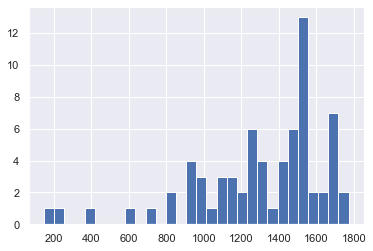

In [94]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
plt.show()

In the [article](https://arxiv.org/pdf/1905.05583.pdf) `How to Fine-Tune BERT for Text Classification?` , Sun et. al. mention that the token limit for BERT models is 512 and they offer the following suggestion:
"Usually, the key information of an article is at the beginning and end.  We use three different methods of truncate text to perform BERT fine-tuning.
- 1.head-only: keep the first 510 tokens6;
- 2.tail-only: keep the last 510 tokens;
- 3.head+tail: empirically select the first 128and the last 382 tokens."

We could do this ourselves but our the most granularity we can obtain are individual posts rather than the large set of posts together (which is what we currently have). What we will do instead is separate each post into one row and analyze it accordingly.

In [95]:
# we make a copy of our dataframe
df_transformers = df[['type','type_label','I','N','T','J','posts']]

In [96]:
df_transformers = df_transformers.sample(n=100)

In [97]:
def transformers_clean(content):
    """This function prepares the posts to be correctly separated"""
    text = content.split('|||')
    text = [re.sub(r'http\S+', '', i) for i in text]
    text = [x for x in text if x.strip(" ")]
    text = [x for x in text if x.strip("'")]
    text = [x.strip() for x in text]
    return text

In [98]:
df_transformers['row'] = df_transformers.apply(lambda row: row.name, axis=1)
df_transformers['text'] = df_transformers['posts'].apply(lambda x: transformers_clean(x))
df_transformers = df_transformers.explode('text', ignore_index=True)

**Let's try again**

In [99]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_transformers['text'], df_transformers['T'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df_transformers['T'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

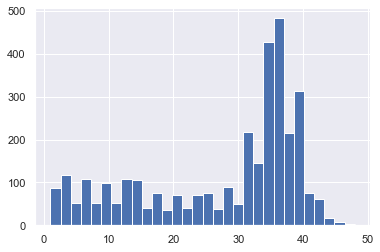

In [100]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
plt.show()

This is more manageable

**Tokenization**

In [101]:
max_seq_len = 50

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

**Convert Integer Sequences to Tensors**

In [102]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

**Create DataLoaders**

In [103]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

**Freeze the parameters**

In [104]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

**Define Model Architecture**

In [105]:
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # relu activation function
        self.relu =  nn.ReLU()
        
        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        
        x = self.fc1(cls_hs)
        
        x = self.relu(x)
        
        x = self.dropout(x)
        
        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [106]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [107]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [108]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.85145482 1.21132898]


In [109]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

**Fine-Tune BERT**

In [110]:
# function to train the model
def train():
    model.train()
    
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)
    
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

**Evaluation**

In [111]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)
            
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            
            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

**Training the Model**

In [112]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in tqdm(range(epochs)):
    
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]


 Epoch 1 / 5


  0%|          | 0/5 [00:02<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

**Save the Model**

In [82]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

RuntimeError: Error(s) in loading state_dict for BertModel:
	Missing key(s) in state_dict: "embeddings.position_ids", "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "encoder.layer.0.attention.self.query.weight", "encoder.layer.0.attention.self.query.bias", "encoder.layer.0.attention.self.key.weight", "encoder.layer.0.attention.self.key.bias", "encoder.layer.0.attention.self.value.weight", "encoder.layer.0.attention.self.value.bias", "encoder.layer.0.attention.output.dense.weight", "encoder.layer.0.attention.output.dense.bias", "encoder.layer.0.attention.output.LayerNorm.weight", "encoder.layer.0.attention.output.LayerNorm.bias", "encoder.layer.0.intermediate.dense.weight", "encoder.layer.0.intermediate.dense.bias", "encoder.layer.0.output.dense.weight", "encoder.layer.0.output.dense.bias", "encoder.layer.0.output.LayerNorm.weight", "encoder.layer.0.output.LayerNorm.bias", "encoder.layer.1.attention.self.query.weight", "encoder.layer.1.attention.self.query.bias", "encoder.layer.1.attention.self.key.weight", "encoder.layer.1.attention.self.key.bias", "encoder.layer.1.attention.self.value.weight", "encoder.layer.1.attention.self.value.bias", "encoder.layer.1.attention.output.dense.weight", "encoder.layer.1.attention.output.dense.bias", "encoder.layer.1.attention.output.LayerNorm.weight", "encoder.layer.1.attention.output.LayerNorm.bias", "encoder.layer.1.intermediate.dense.weight", "encoder.layer.1.intermediate.dense.bias", "encoder.layer.1.output.dense.weight", "encoder.layer.1.output.dense.bias", "encoder.layer.1.output.LayerNorm.weight", "encoder.layer.1.output.LayerNorm.bias", "encoder.layer.2.attention.self.query.weight", "encoder.layer.2.attention.self.query.bias", "encoder.layer.2.attention.self.key.weight", "encoder.layer.2.attention.self.key.bias", "encoder.layer.2.attention.self.value.weight", "encoder.layer.2.attention.self.value.bias", "encoder.layer.2.attention.output.dense.weight", "encoder.layer.2.attention.output.dense.bias", "encoder.layer.2.attention.output.LayerNorm.weight", "encoder.layer.2.attention.output.LayerNorm.bias", "encoder.layer.2.intermediate.dense.weight", "encoder.layer.2.intermediate.dense.bias", "encoder.layer.2.output.dense.weight", "encoder.layer.2.output.dense.bias", "encoder.layer.2.output.LayerNorm.weight", "encoder.layer.2.output.LayerNorm.bias", "encoder.layer.3.attention.self.query.weight", "encoder.layer.3.attention.self.query.bias", "encoder.layer.3.attention.self.key.weight", "encoder.layer.3.attention.self.key.bias", "encoder.layer.3.attention.self.value.weight", "encoder.layer.3.attention.self.value.bias", "encoder.layer.3.attention.output.dense.weight", "encoder.layer.3.attention.output.dense.bias", "encoder.layer.3.attention.output.LayerNorm.weight", "encoder.layer.3.attention.output.LayerNorm.bias", "encoder.layer.3.intermediate.dense.weight", "encoder.layer.3.intermediate.dense.bias", "encoder.layer.3.output.dense.weight", "encoder.layer.3.output.dense.bias", "encoder.layer.3.output.LayerNorm.weight", "encoder.layer.3.output.LayerNorm.bias", "encoder.layer.4.attention.self.query.weight", "encoder.layer.4.attention.self.query.bias", "encoder.layer.4.attention.self.key.weight", "encoder.layer.4.attention.self.key.bias", "encoder.layer.4.attention.self.value.weight", "encoder.layer.4.attention.self.value.bias", "encoder.layer.4.attention.output.dense.weight", "encoder.layer.4.attention.output.dense.bias", "encoder.layer.4.attention.output.LayerNorm.weight", "encoder.layer.4.attention.output.LayerNorm.bias", "encoder.layer.4.intermediate.dense.weight", "encoder.layer.4.intermediate.dense.bias", "encoder.layer.4.output.dense.weight", "encoder.layer.4.output.dense.bias", "encoder.layer.4.output.LayerNorm.weight", "encoder.layer.4.output.LayerNorm.bias", "encoder.layer.5.attention.self.query.weight", "encoder.layer.5.attention.self.query.bias", "encoder.layer.5.attention.self.key.weight", "encoder.layer.5.attention.self.key.bias", "encoder.layer.5.attention.self.value.weight", "encoder.layer.5.attention.self.value.bias", "encoder.layer.5.attention.output.dense.weight", "encoder.layer.5.attention.output.dense.bias", "encoder.layer.5.attention.output.LayerNorm.weight", "encoder.layer.5.attention.output.LayerNorm.bias", "encoder.layer.5.intermediate.dense.weight", "encoder.layer.5.intermediate.dense.bias", "encoder.layer.5.output.dense.weight", "encoder.layer.5.output.dense.bias", "encoder.layer.5.output.LayerNorm.weight", "encoder.layer.5.output.LayerNorm.bias", "encoder.layer.6.attention.self.query.weight", "encoder.layer.6.attention.self.query.bias", "encoder.layer.6.attention.self.key.weight", "encoder.layer.6.attention.self.key.bias", "encoder.layer.6.attention.self.value.weight", "encoder.layer.6.attention.self.value.bias", "encoder.layer.6.attention.output.dense.weight", "encoder.layer.6.attention.output.dense.bias", "encoder.layer.6.attention.output.LayerNorm.weight", "encoder.layer.6.attention.output.LayerNorm.bias", "encoder.layer.6.intermediate.dense.weight", "encoder.layer.6.intermediate.dense.bias", "encoder.layer.6.output.dense.weight", "encoder.layer.6.output.dense.bias", "encoder.layer.6.output.LayerNorm.weight", "encoder.layer.6.output.LayerNorm.bias", "encoder.layer.7.attention.self.query.weight", "encoder.layer.7.attention.self.query.bias", "encoder.layer.7.attention.self.key.weight", "encoder.layer.7.attention.self.key.bias", "encoder.layer.7.attention.self.value.weight", "encoder.layer.7.attention.self.value.bias", "encoder.layer.7.attention.output.dense.weight", "encoder.layer.7.attention.output.dense.bias", "encoder.layer.7.attention.output.LayerNorm.weight", "encoder.layer.7.attention.output.LayerNorm.bias", "encoder.layer.7.intermediate.dense.weight", "encoder.layer.7.intermediate.dense.bias", "encoder.layer.7.output.dense.weight", "encoder.layer.7.output.dense.bias", "encoder.layer.7.output.LayerNorm.weight", "encoder.layer.7.output.LayerNorm.bias", "encoder.layer.8.attention.self.query.weight", "encoder.layer.8.attention.self.query.bias", "encoder.layer.8.attention.self.key.weight", "encoder.layer.8.attention.self.key.bias", "encoder.layer.8.attention.self.value.weight", "encoder.layer.8.attention.self.value.bias", "encoder.layer.8.attention.output.dense.weight", "encoder.layer.8.attention.output.dense.bias", "encoder.layer.8.attention.output.LayerNorm.weight", "encoder.layer.8.attention.output.LayerNorm.bias", "encoder.layer.8.intermediate.dense.weight", "encoder.layer.8.intermediate.dense.bias", "encoder.layer.8.output.dense.weight", "encoder.layer.8.output.dense.bias", "encoder.layer.8.output.LayerNorm.weight", "encoder.layer.8.output.LayerNorm.bias", "encoder.layer.9.attention.self.query.weight", "encoder.layer.9.attention.self.query.bias", "encoder.layer.9.attention.self.key.weight", "encoder.layer.9.attention.self.key.bias", "encoder.layer.9.attention.self.value.weight", "encoder.layer.9.attention.self.value.bias", "encoder.layer.9.attention.output.dense.weight", "encoder.layer.9.attention.output.dense.bias", "encoder.layer.9.attention.output.LayerNorm.weight", "encoder.layer.9.attention.output.LayerNorm.bias", "encoder.layer.9.intermediate.dense.weight", "encoder.layer.9.intermediate.dense.bias", "encoder.layer.9.output.dense.weight", "encoder.layer.9.output.dense.bias", "encoder.layer.9.output.LayerNorm.weight", "encoder.layer.9.output.LayerNorm.bias", "encoder.layer.10.attention.self.query.weight", "encoder.layer.10.attention.self.query.bias", "encoder.layer.10.attention.self.key.weight", "encoder.layer.10.attention.self.key.bias", "encoder.layer.10.attention.self.value.weight", "encoder.layer.10.attention.self.value.bias", "encoder.layer.10.attention.output.dense.weight", "encoder.layer.10.attention.output.dense.bias", "encoder.layer.10.attention.output.LayerNorm.weight", "encoder.layer.10.attention.output.LayerNorm.bias", "encoder.layer.10.intermediate.dense.weight", "encoder.layer.10.intermediate.dense.bias", "encoder.layer.10.output.dense.weight", "encoder.layer.10.output.dense.bias", "encoder.layer.10.output.LayerNorm.weight", "encoder.layer.10.output.LayerNorm.bias", "encoder.layer.11.attention.self.query.weight", "encoder.layer.11.attention.self.query.bias", "encoder.layer.11.attention.self.key.weight", "encoder.layer.11.attention.self.key.bias", "encoder.layer.11.attention.self.value.weight", "encoder.layer.11.attention.self.value.bias", "encoder.layer.11.attention.output.dense.weight", "encoder.layer.11.attention.output.dense.bias", "encoder.layer.11.attention.output.LayerNorm.weight", "encoder.layer.11.attention.output.LayerNorm.bias", "encoder.layer.11.intermediate.dense.weight", "encoder.layer.11.intermediate.dense.bias", "encoder.layer.11.output.dense.weight", "encoder.layer.11.output.dense.bias", "encoder.layer.11.output.LayerNorm.weight", "encoder.layer.11.output.LayerNorm.bias", "pooler.dense.weight", "pooler.dense.bias". 
	Unexpected key(s) in state_dict: "bert.embeddings.position_ids", "bert.embeddings.word_embeddings.weight", "bert.embeddings.position_embeddings.weight", "bert.embeddings.token_type_embeddings.weight", "bert.embeddings.LayerNorm.weight", "bert.embeddings.LayerNorm.bias", "bert.encoder.layer.0.attention.self.query.weight", "bert.encoder.layer.0.attention.self.query.bias", "bert.encoder.layer.0.attention.self.key.weight", "bert.encoder.layer.0.attention.self.key.bias", "bert.encoder.layer.0.attention.self.value.weight", "bert.encoder.layer.0.attention.self.value.bias", "bert.encoder.layer.0.attention.output.dense.weight", "bert.encoder.layer.0.attention.output.dense.bias", "bert.encoder.layer.0.attention.output.LayerNorm.weight", "bert.encoder.layer.0.attention.output.LayerNorm.bias", "bert.encoder.layer.0.intermediate.dense.weight", "bert.encoder.layer.0.intermediate.dense.bias", "bert.encoder.layer.0.output.dense.weight", "bert.encoder.layer.0.output.dense.bias", "bert.encoder.layer.0.output.LayerNorm.weight", "bert.encoder.layer.0.output.LayerNorm.bias", "bert.encoder.layer.1.attention.self.query.weight", "bert.encoder.layer.1.attention.self.query.bias", "bert.encoder.layer.1.attention.self.key.weight", "bert.encoder.layer.1.attention.self.key.bias", "bert.encoder.layer.1.attention.self.value.weight", "bert.encoder.layer.1.attention.self.value.bias", "bert.encoder.layer.1.attention.output.dense.weight", "bert.encoder.layer.1.attention.output.dense.bias", "bert.encoder.layer.1.attention.output.LayerNorm.weight", "bert.encoder.layer.1.attention.output.LayerNorm.bias", "bert.encoder.layer.1.intermediate.dense.weight", "bert.encoder.layer.1.intermediate.dense.bias", "bert.encoder.layer.1.output.dense.weight", "bert.encoder.layer.1.output.dense.bias", "bert.encoder.layer.1.output.LayerNorm.weight", "bert.encoder.layer.1.output.LayerNorm.bias", "bert.encoder.layer.2.attention.self.query.weight", "bert.encoder.layer.2.attention.self.query.bias", "bert.encoder.layer.2.attention.self.key.weight", "bert.encoder.layer.2.attention.self.key.bias", "bert.encoder.layer.2.attention.self.value.weight", "bert.encoder.layer.2.attention.self.value.bias", "bert.encoder.layer.2.attention.output.dense.weight", "bert.encoder.layer.2.attention.output.dense.bias", "bert.encoder.layer.2.attention.output.LayerNorm.weight", "bert.encoder.layer.2.attention.output.LayerNorm.bias", "bert.encoder.layer.2.intermediate.dense.weight", "bert.encoder.layer.2.intermediate.dense.bias", "bert.encoder.layer.2.output.dense.weight", "bert.encoder.layer.2.output.dense.bias", "bert.encoder.layer.2.output.LayerNorm.weight", "bert.encoder.layer.2.output.LayerNorm.bias", "bert.encoder.layer.3.attention.self.query.weight", "bert.encoder.layer.3.attention.self.query.bias", "bert.encoder.layer.3.attention.self.key.weight", "bert.encoder.layer.3.attention.self.key.bias", "bert.encoder.layer.3.attention.self.value.weight", "bert.encoder.layer.3.attention.self.value.bias", "bert.encoder.layer.3.attention.output.dense.weight", "bert.encoder.layer.3.attention.output.dense.bias", "bert.encoder.layer.3.attention.output.LayerNorm.weight", "bert.encoder.layer.3.attention.output.LayerNorm.bias", "bert.encoder.layer.3.intermediate.dense.weight", "bert.encoder.layer.3.intermediate.dense.bias", "bert.encoder.layer.3.output.dense.weight", "bert.encoder.layer.3.output.dense.bias", "bert.encoder.layer.3.output.LayerNorm.weight", "bert.encoder.layer.3.output.LayerNorm.bias", "bert.encoder.layer.4.attention.self.query.weight", "bert.encoder.layer.4.attention.self.query.bias", "bert.encoder.layer.4.attention.self.key.weight", "bert.encoder.layer.4.attention.self.key.bias", "bert.encoder.layer.4.attention.self.value.weight", "bert.encoder.layer.4.attention.self.value.bias", "bert.encoder.layer.4.attention.output.dense.weight", "bert.encoder.layer.4.attention.output.dense.bias", "bert.encoder.layer.4.attention.output.LayerNorm.weight", "bert.encoder.layer.4.attention.output.LayerNorm.bias", "bert.encoder.layer.4.intermediate.dense.weight", "bert.encoder.layer.4.intermediate.dense.bias", "bert.encoder.layer.4.output.dense.weight", "bert.encoder.layer.4.output.dense.bias", "bert.encoder.layer.4.output.LayerNorm.weight", "bert.encoder.layer.4.output.LayerNorm.bias", "bert.encoder.layer.5.attention.self.query.weight", "bert.encoder.layer.5.attention.self.query.bias", "bert.encoder.layer.5.attention.self.key.weight", "bert.encoder.layer.5.attention.self.key.bias", "bert.encoder.layer.5.attention.self.value.weight", "bert.encoder.layer.5.attention.self.value.bias", "bert.encoder.layer.5.attention.output.dense.weight", "bert.encoder.layer.5.attention.output.dense.bias", "bert.encoder.layer.5.attention.output.LayerNorm.weight", "bert.encoder.layer.5.attention.output.LayerNorm.bias", "bert.encoder.layer.5.intermediate.dense.weight", "bert.encoder.layer.5.intermediate.dense.bias", "bert.encoder.layer.5.output.dense.weight", "bert.encoder.layer.5.output.dense.bias", "bert.encoder.layer.5.output.LayerNorm.weight", "bert.encoder.layer.5.output.LayerNorm.bias", "bert.encoder.layer.6.attention.self.query.weight", "bert.encoder.layer.6.attention.self.query.bias", "bert.encoder.layer.6.attention.self.key.weight", "bert.encoder.layer.6.attention.self.key.bias", "bert.encoder.layer.6.attention.self.value.weight", "bert.encoder.layer.6.attention.self.value.bias", "bert.encoder.layer.6.attention.output.dense.weight", "bert.encoder.layer.6.attention.output.dense.bias", "bert.encoder.layer.6.attention.output.LayerNorm.weight", "bert.encoder.layer.6.attention.output.LayerNorm.bias", "bert.encoder.layer.6.intermediate.dense.weight", "bert.encoder.layer.6.intermediate.dense.bias", "bert.encoder.layer.6.output.dense.weight", "bert.encoder.layer.6.output.dense.bias", "bert.encoder.layer.6.output.LayerNorm.weight", "bert.encoder.layer.6.output.LayerNorm.bias", "bert.encoder.layer.7.attention.self.query.weight", "bert.encoder.layer.7.attention.self.query.bias", "bert.encoder.layer.7.attention.self.key.weight", "bert.encoder.layer.7.attention.self.key.bias", "bert.encoder.layer.7.attention.self.value.weight", "bert.encoder.layer.7.attention.self.value.bias", "bert.encoder.layer.7.attention.output.dense.weight", "bert.encoder.layer.7.attention.output.dense.bias", "bert.encoder.layer.7.attention.output.LayerNorm.weight", "bert.encoder.layer.7.attention.output.LayerNorm.bias", "bert.encoder.layer.7.intermediate.dense.weight", "bert.encoder.layer.7.intermediate.dense.bias", "bert.encoder.layer.7.output.dense.weight", "bert.encoder.layer.7.output.dense.bias", "bert.encoder.layer.7.output.LayerNorm.weight", "bert.encoder.layer.7.output.LayerNorm.bias", "bert.encoder.layer.8.attention.self.query.weight", "bert.encoder.layer.8.attention.self.query.bias", "bert.encoder.layer.8.attention.self.key.weight", "bert.encoder.layer.8.attention.self.key.bias", "bert.encoder.layer.8.attention.self.value.weight", "bert.encoder.layer.8.attention.self.value.bias", "bert.encoder.layer.8.attention.output.dense.weight", "bert.encoder.layer.8.attention.output.dense.bias", "bert.encoder.layer.8.attention.output.LayerNorm.weight", "bert.encoder.layer.8.attention.output.LayerNorm.bias", "bert.encoder.layer.8.intermediate.dense.weight", "bert.encoder.layer.8.intermediate.dense.bias", "bert.encoder.layer.8.output.dense.weight", "bert.encoder.layer.8.output.dense.bias", "bert.encoder.layer.8.output.LayerNorm.weight", "bert.encoder.layer.8.output.LayerNorm.bias", "bert.encoder.layer.9.attention.self.query.weight", "bert.encoder.layer.9.attention.self.query.bias", "bert.encoder.layer.9.attention.self.key.weight", "bert.encoder.layer.9.attention.self.key.bias", "bert.encoder.layer.9.attention.self.value.weight", "bert.encoder.layer.9.attention.self.value.bias", "bert.encoder.layer.9.attention.output.dense.weight", "bert.encoder.layer.9.attention.output.dense.bias", "bert.encoder.layer.9.attention.output.LayerNorm.weight", "bert.encoder.layer.9.attention.output.LayerNorm.bias", "bert.encoder.layer.9.intermediate.dense.weight", "bert.encoder.layer.9.intermediate.dense.bias", "bert.encoder.layer.9.output.dense.weight", "bert.encoder.layer.9.output.dense.bias", "bert.encoder.layer.9.output.LayerNorm.weight", "bert.encoder.layer.9.output.LayerNorm.bias", "bert.encoder.layer.10.attention.self.query.weight", "bert.encoder.layer.10.attention.self.query.bias", "bert.encoder.layer.10.attention.self.key.weight", "bert.encoder.layer.10.attention.self.key.bias", "bert.encoder.layer.10.attention.self.value.weight", "bert.encoder.layer.10.attention.self.value.bias", "bert.encoder.layer.10.attention.output.dense.weight", "bert.encoder.layer.10.attention.output.dense.bias", "bert.encoder.layer.10.attention.output.LayerNorm.weight", "bert.encoder.layer.10.attention.output.LayerNorm.bias", "bert.encoder.layer.10.intermediate.dense.weight", "bert.encoder.layer.10.intermediate.dense.bias", "bert.encoder.layer.10.output.dense.weight", "bert.encoder.layer.10.output.dense.bias", "bert.encoder.layer.10.output.LayerNorm.weight", "bert.encoder.layer.10.output.LayerNorm.bias", "bert.encoder.layer.11.attention.self.query.weight", "bert.encoder.layer.11.attention.self.query.bias", "bert.encoder.layer.11.attention.self.key.weight", "bert.encoder.layer.11.attention.self.key.bias", "bert.encoder.layer.11.attention.self.value.weight", "bert.encoder.layer.11.attention.self.value.bias", "bert.encoder.layer.11.attention.output.dense.weight", "bert.encoder.layer.11.attention.output.dense.bias", "bert.encoder.layer.11.attention.output.LayerNorm.weight", "bert.encoder.layer.11.attention.output.LayerNorm.bias", "bert.encoder.layer.11.intermediate.dense.weight", "bert.encoder.layer.11.intermediate.dense.bias", "bert.encoder.layer.11.output.dense.weight", "bert.encoder.layer.11.output.dense.bias", "bert.encoder.layer.11.output.LayerNorm.weight", "bert.encoder.layer.11.output.LayerNorm.bias", "bert.pooler.dense.weight", "bert.pooler.dense.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

**Test Data Predictions**

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

In [22]:
class MBTIDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df):
        'Initialization'
        self.df = df

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = df['text_clean_joined']
        y = df['type'] 

        return X, y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8675 entries, 0 to 8674
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   type                          8675 non-null   object 
 1   type_label                    8675 non-null   int64  
 2   posts                         8675 non-null   object 
 3   I                             8675 non-null   int64  
 4   J                             8675 non-null   int64  
 5   N                             8675 non-null   int64  
 6   T                             8675 non-null   int64  
 7   NF                            8675 non-null   int64  
 8   NT                            8675 non-null   int64  
 9   SP                            8675 non-null   int64  
 10  SJ                            8675 non-null   int64  
 11  text_clean                    8675 non-null   object 
 12  pos_tags                      8675 non-null   object 
 13  syl

In [25]:
# Parameters
params = {'batch_size': 8,
          'shuffle': False, # Change me at some point
          'num_workers': 6}

training_generator = DataLoader(training_set, **params)

NameError: name 'training_set' is not defined

In [21]:
model = AutoModel.from_pretrained('distilbert-base-uncased')

In [27]:
# Training Loop Params
max_epochs=1
device='cpu'  # change to gpu when money flowsss...

In [ ]:
# Loop over epochs. We are gonna play with train and dev datasets
for epoch in range(max_epochs):
    # Training (Train dataset)
    for batch, labels in training_generator:
        # Transfer to GPU
        batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        model...

    # Validation (Dev dataset)
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            [...]


            

In [ ]:
# Inference. We play with the test dataset
# Validation (Dev dataset)
with torch.set_grad_enabled(False):

    for batch, labels in test_generator:
        # Transfer to GPU
        batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        model...

<a id=paperspace></a>

## Paperspace Example

In [74]:
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer

torch.set_grad_enabled(False)

In [75]:
# Store the model we want to use
MODEL_NAME = "bert-base-cased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

With only the above two lines of code, you're ready to use a BERT pre-trained model. The tokenizers will allow us to map a raw textual input to a sequence of integers representing our textual input in a way the model can manipulate.

In [76]:
# Tokens comes from a process that splits the input into sub-entities with interesting linguistic properties. 
tokens = tokenizer.tokenize("This is an input example")
print("Tokens: {}".format(tokens))

# This is not sufficient for the model, as it requires integers as input, 
# not a problem, let's convert tokens to ids.
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Tokens id: {}".format(tokens_ids))

# Add the required special tokens
tokens_ids = tokenizer.build_inputs_with_special_tokens(tokens_ids)

# We need to convert to a Deep Learning framework specific format, let's use PyTorch for now.
tokens_pt = torch.tensor([tokens_ids])
print("Tokens PyTorch: {}".format(tokens_pt))

# Now we're ready to go through BERT with out input
outputs, pooled = model(tokens_pt)
print("Token wise output: {}, Pooled output: {}".format(outputs.shape, pooled.shape))

Tokens: ['This', 'is', 'an', 'input', 'example']
Tokens id: [1188, 1110, 1126, 7758, 1859]
Tokens PyTorch: tensor([[ 101, 1188, 1110, 1126, 7758, 1859,  102]])
Token wise output: torch.Size([1, 7, 768]), Pooled output: torch.Size([1, 768])


As you can see, BERT outputs two tensors:

- One with the generated representation for every token in the input (1, NB_TOKENS, REPRESENTATION_SIZE)
- One with an aggregated representation for the whole input (1, REPRESENTATION_SIZE)

The first, token-based, representation can be leveraged if your task requires to keep the sequence representation and you want to operate at a token-level. This is particularly useful for Named Entity Recognition and Question-Answering.

The second, aggregated, representation is especially useful if you need to extract the overall context of the sequence and don't require a fine-grained token-leven. This is the case for Sentiment-Analysis of the sequence or Information Retrieval.

The code you saw in the previous section introduced all the steps required to do simple model invocation. For more day-to-day usage, transformers provides you higher-level methods which will makes your NLP journey easier Let's improve our previous example

In [77]:
# This code can be factored into one-line as follow
tokens_pt2 = tokenizer.encode_plus("This is an input example", return_tensors="pt")

for key, value in tokens_pt2.items():
    print("{}:\n\t{}".format(key, value))

outputs2, pooled2 = model(**tokens_pt2)
print("Difference with previous code: ({}, {})".format((outputs2 - outputs).sum(), (pooled2 - pooled).sum()))

input_ids:
	tensor([[ 101, 1188, 1110, 1126, 7758, 1859,  102]])
token_type_ids:
	tensor([[0, 0, 0, 0, 0, 0, 0]])
attention_mask:
	tensor([[1, 1, 1, 1, 1, 1, 1]])
Difference with previous code: (0.0, 0.0)


As you can see above, the methode `encode_plus` provides a convenient way to generate all the required parameters
that will go through the model. 

Moreover, you might have noticed it generated some additional tensors: 

- token_type_ids: This tensor will map every tokens to their corresponding segment (see below).
- attention_mask: This tensor is used to "mask" padded values in a batch of sequence with different lengths (see below).

In [78]:
# Single segment input
single_seg_input = tokenizer.encode_plus("This is a sample input")

# Multiple segment input
multi_seg_input = tokenizer.encode_plus("This is segment A", "This is segment B")

print("Single segment token (str): {}".format(tokenizer.convert_ids_to_tokens(single_seg_input['input_ids'])))
print("Single segment token (int): {}".format(single_seg_input['input_ids']))
print("Single segment type       : {}".format(single_seg_input['token_type_ids']))

# Segments are concatened in the input to the model, with 
print()
print("Multi segment token (str): {}".format(tokenizer.convert_ids_to_tokens(multi_seg_input['input_ids'])))
print("Multi segment token (int): {}".format(multi_seg_input['input_ids']))
print("Multi segment type       : {}".format(multi_seg_input['token_type_ids']))

Single segment token (str): ['[CLS]', 'This', 'is', 'a', 'sample', 'input', '[SEP]']
Single segment token (int): [101, 1188, 1110, 170, 6876, 7758, 102]
Single segment type       : [0, 0, 0, 0, 0, 0, 0]

Multi segment token (str): ['[CLS]', 'This', 'is', 'segment', 'A', '[SEP]', 'This', 'is', 'segment', 'B', '[SEP]']
Multi segment token (int): [101, 1188, 1110, 6441, 138, 102, 1188, 1110, 6441, 139, 102]
Multi segment type       : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [80]:
# Padding highlight
tokens = tokenizer.batch_encode_plus(
    ["This is a sample", "This is another longer sample text"], 
    pad_to_max_length=True  # First sentence will have some PADDED tokens to match second sequence length
)

for i in range(2):
    print("Tokens (int)      : {}".format(tokens['input_ids'][i]))
    print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in tokens['input_ids'][i]]))
    print("Tokens (attn_mask): {}".format(tokens['attention_mask'][i]))
    print()

Tokens (int)      : [101, 1188, 1110, 170, 6876, 102, 0, 0]
Tokens (str)      : ['[CLS]', 'This', 'is', 'a', 'sample', '[SEP]', '[PAD]', '[PAD]']
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 0, 0]

Tokens (int)      : [101, 1188, 1110, 1330, 2039, 6876, 3087, 102]
Tokens (str)      : ['[CLS]', 'This', 'is', 'another', 'longer', 'sample', 'text', '[SEP]']
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1]



### Frameworks interoperability

One of the most powerfull feature of transformers is its ability to seamlessly move from PyTorch to Tensorflow
without pain for the user.

We provide some convenient methods to load TensorFlow pretrained weight insinde a PyTorch model and opposite.

In [84]:
from transformers import TFBertModel, BertModel

# Let's load a BERT model for TensorFlow and PyTorch
model_tf = TFBertModel.from_pretrained('bert-base-cased')
model_pt = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [85]:
# transformers generates a ready to use dictionary with all the required parameters for the specific framework.
input_tf = tokenizer.encode_plus("This is a sample input", return_tensors="tf")
input_pt = tokenizer.encode_plus("This is a sample input", return_tensors="pt")

# Let's compare the outputs
output_tf, output_pt = model_tf(input_tf), model_pt(**input_pt)

# Models outputs 2 values (The value for each tokens, the pooled representation of the input sentence)
# Here we compare the output differences between PyTorch and TensorFlow.
for name, o_tf, o_pt in zip(["output", "pooled"], output_tf, output_pt):
    print("{} differences: {}".format(name, (o_tf.numpy() - o_pt.numpy()).sum()))

output differences: 1.5355180948972702e-05
pooled differences: -1.1511147022247314e-06


#### Want it lighter? Faster? Let's talk distillation! 

One of the main concerns when using these Transformer based models is the computational power they require. All over this notebook we are using BERT model as it can be run on common machines but that's not the case for all of the models.

For example, Google released a few months ago **T5** an Encoder/Decoder architecture based on Transformer and available in `transformers` with no more than 11 billions parameters. Microsoft also recently entered the game with **Turing-NLG** using 17 billions parameters. This kind of model requires tens of gigabytes to store the weights and a tremendous compute infrastructure to run such models which makes it impracticable for the common man !

With the goal of making Transformer-based NLP accessible to everyone we @huggingface developed models that take advantage of a training process called **Distillation** which allows us to drastically reduce the resources needed to run such models with almost zero drop in performances.

Going over the whole Distillation process is out of the scope of this notebook, but if you want more information on the subject you may refer to [this Medium article written by my colleague Victor SANH, author of DistilBERT paper](https://medium.com/huggingface/distilbert-8cf3380435b5), you might also want to directly have a look at the paper [(Sanh & al., 2019)](https://arxiv.org/abs/1910.01108)

Of course, in `transformers` we have distilled some models and made them available directly in the library ! 

In [86]:
from transformers import DistilBertModel

bert_distil = DistilBertModel.from_pretrained('distilbert-base-cased')
input_pt = tokenizer.encode_plus(
    'This is a sample input to demonstrate performance of distiled models especially inference time', 
    return_tensors="pt"
)


%time _ = bert_distil(input_pt['input_ids'])
%time _ = model_pt(input_pt['input_ids'])


CPU times: user 123 ms, sys: 2.63 ms, total: 125 ms
Wall time: 107 ms
CPU times: user 242 ms, sys: 3.95 ms, total: 246 ms
Wall time: 244 ms


**Pipelines encapsulate the overall process of every NLP process:**

- Tokenization: Split the initial input into multiple sub-entities with ... properties (i.e. tokens).
- Inference: Maps every tokens into a more meaningful representation.
- Decoding: Use the above representation to generate and/or extract the final output for the underlying task.

```python
from transformers import pipeline

# Using default model and tokenizer for the task
pipeline("<task-name>")

# Using a user-specified model
pipeline("<task-name>", model="<model_name>")

# Using custom model/tokenizer as str
pipeline('<task-name>', model='<model name>', tokenizer='<tokenizer_name>')
```

<a id='logistic'></a>

## BEST MODELS

[Go to top](#top)

<br>
<div class="span5 alert alert-info">
    <H3>LOGISTIC REGRESSION MODELS</H3>
</div>

In [26]:
df = pd.read_csv('../../data/mbti_nlp.csv', index_col=0)

In [27]:
# we make a copy of our dataframe
df_long = df[['type','type_label','I','N','T','J','posts']]

In [28]:
def expand_posts(content):
    """This function prepares the posts to be correctly separated"""
    text = content.split('|||')
    text = [re.sub(r'http\S+', '', i) for i in text]
    text = [x for x in text if x.strip(" ")]
    text = [x for x in text if x.strip("'")]
    text = [x.strip() for x in text]
    return text

In [29]:
df_long['row'] = df_long.apply(lambda row: row.name, axis=1)
df_long['text'] = df_long['posts'].apply(lambda x: expand_posts(x))
df_long = df_long.explode('text', ignore_index=True)

In [34]:
df = df_long.drop('posts', axis=1)

In [37]:
#remove stop words function
def remove_stop_words( x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)  
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)

In [38]:
# MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types = [x.lower() for x in df['type'].unique()] 
types_plural = [x+'s' for x in types]

# some words that appear a lot but do not add value
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf', 'ti','se','op','ne'] 

# We put these together and include the normal stopwords from the English language
stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

In [41]:
df['text_clean'] = df['text'].progress_apply(lambda x : remove_stop_words(x, stop_words))

Progress!: 100%|██████████| 411107/411107 [00:08<00:00, 48765.09it/s]


In [44]:
df.head()

,type,type_label,I,N,T,J,row,text,text_clean
0,INFJ,8,1,1,0,1,0,enfp and intj moments sportscenter not top ...,moments sportscenter plays pranks
1,INFJ,8,1,1,0,1,0,What has been the most life-changing experienc...,life changing experience life
2,INFJ,8,1,1,0,1,0,On repeat for most of today.,repeat today
3,INFJ,8,1,1,0,1,0,May the PerC Experience immerse you.,perc experience immerse
4,INFJ,8,1,1,0,1,0,The last thing my INFJ friend posted on his fa...,thing friend posted facebook committing suicid...


In [ ]:
#this calculates the TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.05, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words)
features = tfidf.fit_transform(df.description_clean).toarray()
labels = df.label
features.shape

In [20]:
df = T.copy()
X_train, X_test, y_train, y_test = train_test_split(df[TEXT], df[LABEL], test_size=0.25, random_state=42, stratify=df[LABEL])

<br>

I will try to replicate [this great notebook](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb) by Emmanuel Ameisen

<a id='logistic_cv'></a>

### 1st Model - Logistic Regression Model with CountVectorizer

In [10]:
def cv(data):
    count_vectorizer = CountVectorizer(min_df=0.1, max_df=0.9, stop_words=stop_words)

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer


X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [11]:
print(len(X_train_counts.todense()))
print(len(count_vectorizer.get_feature_names()))

6940
725


<br>

**Note to self:** including all the words apparently has a positive effect in accuracy, recall, and precision. I think this is due to the MBTI types themselves. Taking them out I think is a good idea since it will generalize better to other contexts where people do not use these kind of terms.

<br>

**Visualizing the embeddings**

Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 296 dimensions is hard, let's project it down to 2. For this Ameisen uses Principal Component Analysis


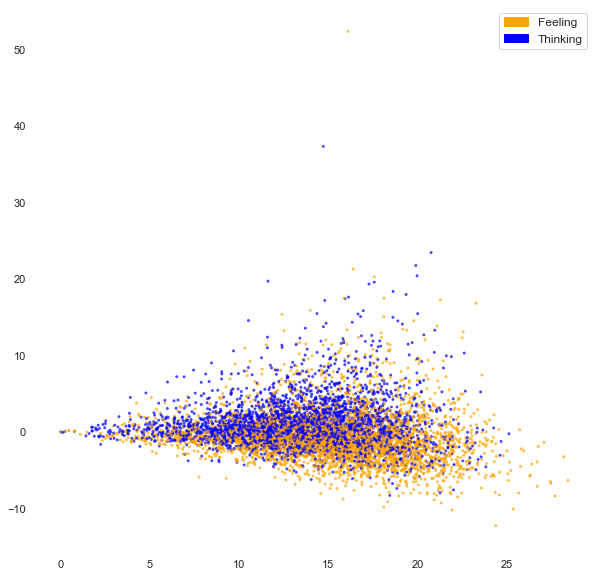

In [12]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=4, alpha=.6, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Feeling')
            blue_patch = mpatches.Patch(color='blue', label='Thinking')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 12})

fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.savefig('img/CountVectorizer_Feeling_Thinking.png', dpi=100, transparent=True)
plt.show()

<br>

**Fitting a classifier**

Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.


In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

<br>

**Evaluation**

Let's start by looking at some metrics to see if our classifier performed well at all.

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.742, precision = 0.742, recall = 0.742, f1 = 0.742


<br>

**Inspection**

A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.


In [15]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, pad=30)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15, labelpad=15)
    plt.xlabel('Predicted label', fontsize=15, labelpad=30)

    return plt

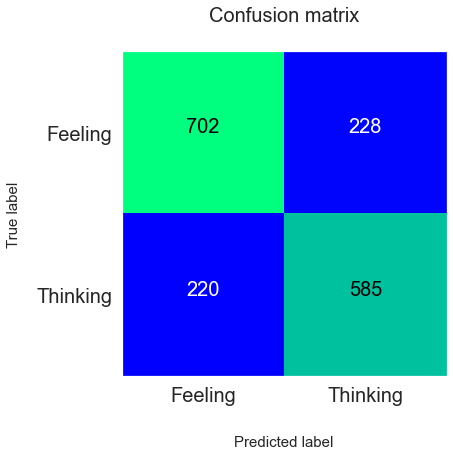

In [16]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Feeling','Thinking'], normalize=False, title='Confusion matrix')
plt.savefig('img/CountVectorizer_Feeling_Thinking_cm.png', dpi=100, transparent=True)
plt.show()
#print(cm)

<br>

**Further inspection**

Let's look at the features our classifier is using to make decisions.

In [17]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

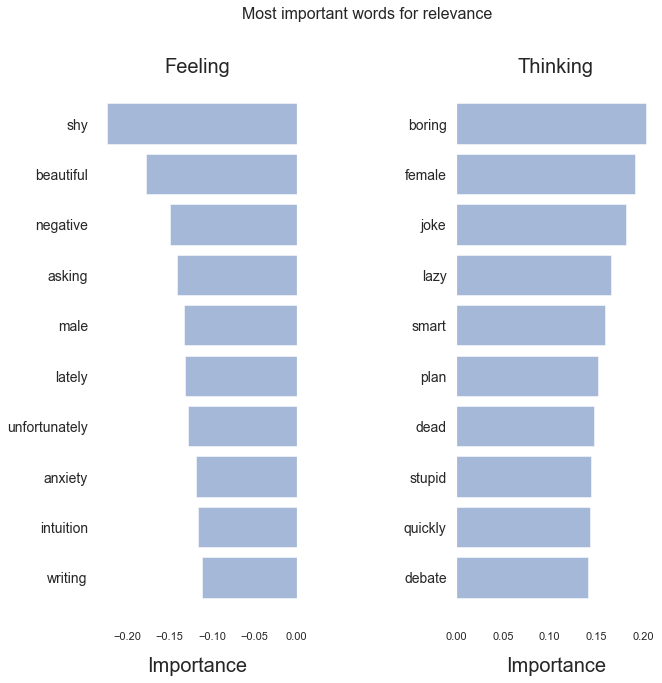

In [18]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name, save_as):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Feeling', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20, labelpad=15)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Thinking', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20, labelpad=15)
    
    plt.subplots_adjust(wspace=0.8)
    plt.savefig(save_as, dpi=100, transparent=True)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance",
                    save_as='img/CountVectorizer_Feeling_Thinking_features.png')


<a id='logistic_tf'></a>

### 2nd Model - Logistic Regression with TF-IDF

Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

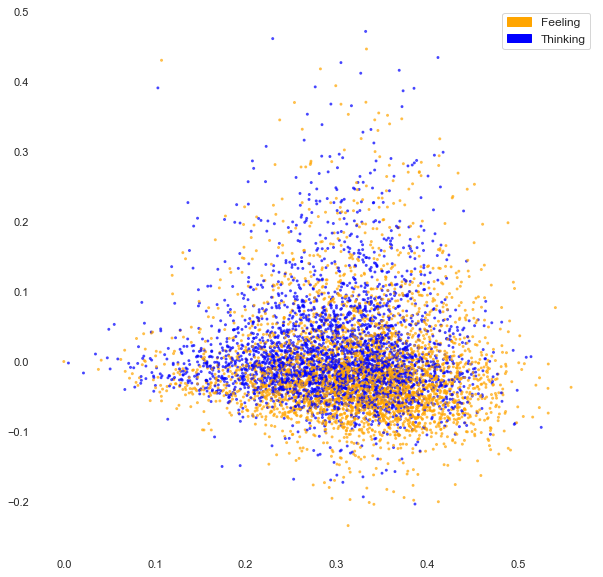

In [22]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.savefig('img/TF_IDF_Feeling_Thinking.png', dpi=100, transparent=True)
plt.show()

In [23]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [24]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.795, precision = 0.795, recall = 0.795, f1 = 0.794


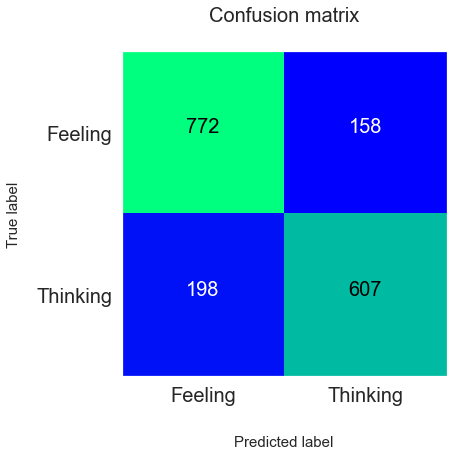

TFIDF confusion matrix
[[772 158]
 [198 607]]
BoW confusion matrix
[[702 228]
 [220 585]]


In [25]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm2, classes=['Feeling','Thinking'], normalize=False, title='Confusion matrix')
plt.savefig('img/TF_IDF_Feeling_Thinking_cm.png', dpi=100, transparent=True)
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

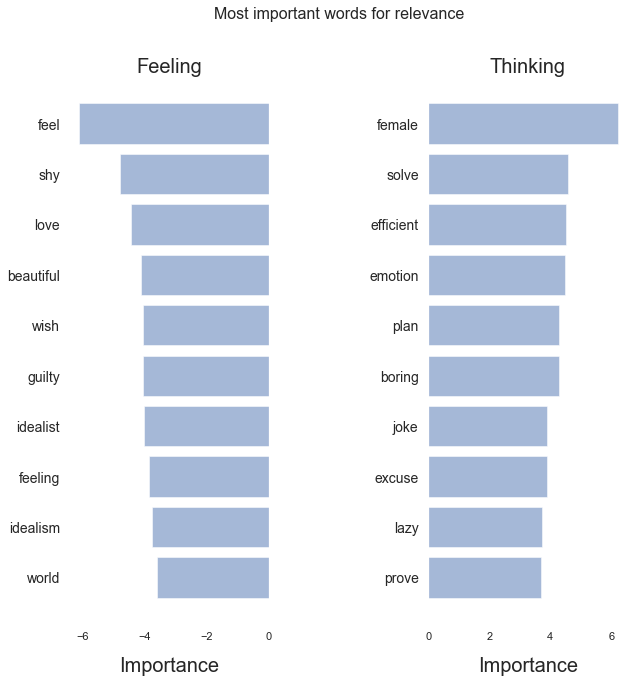

In [26]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance", 
                    save_as='img/TF_IDF_Feeling_Thinking_features.png')

<a id='logistic_wv'></a>

### 3rd Model - Logistic Regression Model with Word2Vec

<br>

**Capturing semantic meaning**

Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. Meaning we need to understand that words like 'good' and 'positive' are closer than apricot and 'continent'.

**Enter word2vec**

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [27]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=2000000)

In [28]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = df['text_clean'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [29]:
embeddings = get_word2vec_embeddings(word2vec, df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

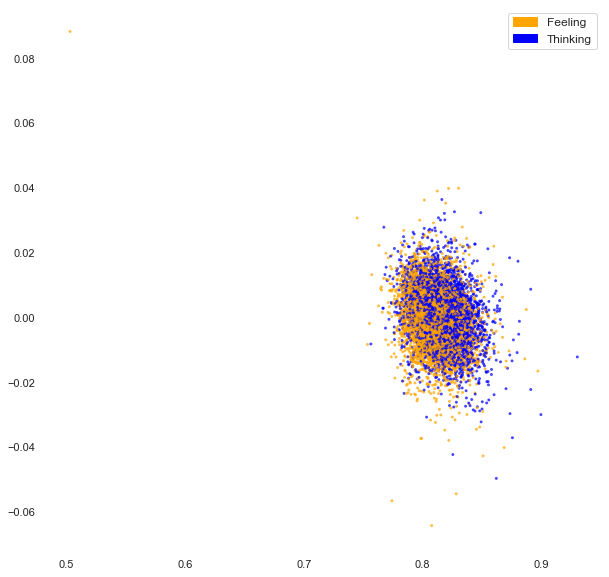

In [30]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.savefig('img/Word2Vec_Feeling_Thinking.png', dpi=100, transparent=True)
plt.show()

In [31]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [32]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.674, precision = 0.675, recall = 0.674, f1 = 0.674


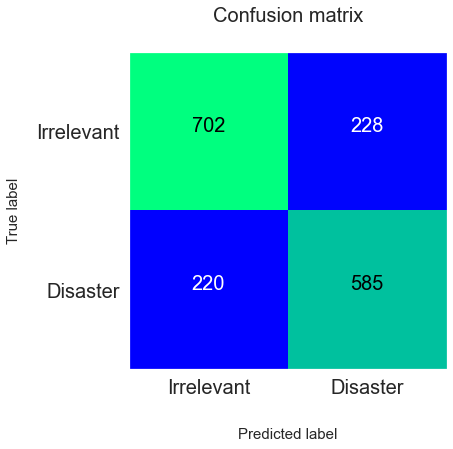

Word2Vec confusion matrix
[[629 301]
 [265 540]]

TFIDF confusion matrix
[[772 158]
 [198 607]]

BoW confusion matrix
[[702 228]
 [220 585]]


In [33]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.savefig('img/Word2Vec_Feeling_Thinking_cm.png', dpi=100, transparent=True)
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print()
print("TFIDF confusion matrix")
print(cm2)
print()
print("BoW confusion matrix")
print(cm)

<a id='naive_bayes'></a>

<br>
<div class="span5 alert alert-info">
    <H3>MULTINOMIAL NAIVE BAYES MODELS</H3>
</div>

### Train Test Split

In [34]:
# we create a function that applies countvectorizer to our data and separates it between our predictors and our target variable
def make_xy(dataframe, text_column, target, vectorizer=None):
    """Creates the X and y arrays, the X as a CountVectorized numpy array and the y as a binomial array"""    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=0.1,max_df=0.9, stop_words=stop_words)
    X = vectorizer.fit_transform(dataframe[text_column])
    X = X.tocsc() 
    y = dataframe[target]
    return X, y

X, y = make_xy(df, 'text_clean_joined', 'T')

# let's check how many of each class we have to understand how imbalanced our dataset is
np.unique(y, return_counts=True)

# now let's separate the data into the train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

<a id='multinomial'></a>

### 1st Model - Multinomial NB

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [36]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print()
print(accuracy_score(y_train,clf.predict(X_train)))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      3284
           1       0.73      0.72      0.72      2789

    accuracy                           0.75      6073
   macro avg       0.74      0.74      0.74      6073
weighted avg       0.75      0.75      0.75      6073

[[2528  756]
 [ 783 2006]]

0.7732513451191392
0.7465832372797628


<a id='multinomial2'></a>

### 2nd Model - Multinomial NB with crossvalidation

In [38]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X):      # split data into train/test groups, 5 times
        clf.fit(X[train], ytrainthis.reset_index(drop=True).T[train])                # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], ytrainthis.reset_index(drop=True).T[test]) # evaluate score function on held-out data
    return result / nfold                          # average

We will use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`. The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, `precision`, `recall`, or `F1-score` as the scoring function.

In [39]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    zero = y == 0
    one = ~zero
    return prob[zero, 0].sum() + prob[one, 1].sum()

In [40]:
_, itest = train_test_split(range(df.shape[0]), train_size=0.7, random_state=42)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itest] = True

In [41]:
#the grid of parameters to search over
alphas = [0.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in tqdm(min_dfs):         
        vectorizer = CountVectorizer(min_df = min_df, max_df=0.9, stop_words=stop_words)       
        Xthis, ythis = make_xy(df, 'text_clean_joined', 'T', vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

100%|██████████| 5/5 [2:01:20<00:00, 1456.16s/it]  


In [42]:
print("alpha: %f" % best_alpha)
print("min_df: %f" % best_min_df)

alpha: 50.000000
min_df: 0.100000


In [43]:
vectorizer = CountVectorizer(min_df = 0.1, max_df=0.9, stop_words=stop_words)
X, y = make_xy(df, 'text_clean_joined', 'T', vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

clf = MultinomialNB(alpha=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print()
print(accuracy_score(y_train,clf.predict(X_train)))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3284
           1       0.74      0.67      0.70      2789

    accuracy                           0.74      6073
   macro avg       0.74      0.73      0.74      6073
weighted avg       0.74      0.74      0.74      6073

[[2622  662]
 [ 920 1869]]

0.7686395080707148
0.7395027169438498


**Conclusion:** the best parameters give us a lower accuracy score, they seem to do better in classifying "Feeling" types (our 0 class) but overall it is very similar to the previous model.

In [45]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(X_test.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(T | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(F | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
        intelligence 0.62
            research 0.61
                math 0.61
              debate 0.61
                  ti 0.61
             science 0.61
                fuck 0.60
                rule 0.60
               brain 0.60
                shit 0.60
Bad words	     P(fresh | word)
                dear 0.34
               loved 0.33
                glad 0.33
                love 0.33
                soul 0.33
                song 0.32
                feel 0.32
                  hi 0.30
                  xd 0.30
           beautiful 0.29


In [48]:
x, y = make_xy(df, 'text_clean_joined', 'T', vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_F = np.argsort(prob[y == 0])[:3]
bad_T = np.argsort(prob[y == 1])[-3:]

print("Mis-predicted Feeling Type ")
print('---------------------------')
for row in bad_F:
    print(df[y == 0].iloc[row,2][0:1000])
    print("")

print("Mis-predicted Thinking Type")
print('--------------------------')
for row in bad_T:
    print(df[y == 1].iloc[row,2][0:1000])
    print("")

Mis-predicted Feeling Type 
---------------------------
MBTI:  Subtype: Compatible Matches:  Cognitive Functions:   Global 5:   Enneagram Triptype: Variant:   Archetype:  Bloodtype:  Genotype:|||http://www.youtube.com/watch?v=DKfDaKzk3B8|||Are you Schizo, Borderline, or Narcissistic? I am Borderline. Also, I am the Hermit but occasionally the Waif.  What's your personal order of cognitive functions? Fi, Ne, Ti, Si, Fe, Te, Ni, Se ...|||change this one to widdlewiddle for privacy reasons or just delete this account altogether. this name was automatically generated from my facebook account.|||Copy and paste this and then fill it in:  Your type: Your spouse's type: Describe the relationship quality:  Describe how you are best friends: Describe how your relationship has grown and the...|||In your opinion, which MBTI type is the most compassionate and why? Are only feelers compassionate? Share your thoughts...|||I don't see an exit door. My responsibilities have me trapped. The world is a l

<br>

Emmanuel also uses CNNs (Convolutional Neural Networks) for text classification but for the time being I will leave it here. I need to process what I learned up to now. In our first models it seems that the TFIDF did the best in labeling mbti type `Thinking` and `Feeling`, we could also load more words from the `GoogleNews-vectors-negative300.bin.gz` pretrained model. Maybe it helps boost the Word2Vec predictive power since it includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset.